# Assignment 4: Convolutional Neural Networks

In [1]:
import json
import os
import sys
import shutil
from typing import Literal, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import wandb

PROJECT_DIR = '../..'
sys.path.insert(0, PROJECT_DIR)

from models.cnn import CNN

## Classification using CNN

### Data Loading and Preprocessing

In [2]:
def load_mnist_data(
    dataset_path: str, split: Literal['train', 'val', 'test'], count_digits: bool = False
) -> Tuple[npt.NDArray[float], npt.NDArray[str | int]]:
    """ Loads the images and labels for a split of the Multi MNIST (double_mnist) dataset. """

    # Image, label pairs
    X, y = [], []

    for descriptor in os.listdir(f'{dataset_path}/{split}'):

        # Label
        if count_digits:
            label = [len(descriptor)] if descriptor != '0' else [0]
        else:
            label = descriptor

        # Image
        for image_path in os.listdir(f'{dataset_path}/{split}/{descriptor}'):
            image = cv2.imread(f'{dataset_path}/{split}/{descriptor}/{image_path}', 0)
            image = image.astype(np.float32) / 255.0
            image = np.expand_dims(image, axis=0)

            # Store image and label
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y)

def one_hot_encoding(labels: npt.NDArray[str]) -> npt.NDArray[float]:
    """ Creates one hot encoded vectors for each label value. """

    out = []
    for label in labels:
        encoding = np.zeros((3, 10))
        if label != '0':
            encoding[range(len(label)), [int(digit) for digit in label]] = 1
        out.append(encoding)
    return np.array(out)

In [3]:
class MultiMNISTDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, split: Literal['train', 'val', 'test'], \
                                                                task: Literal['count', 'predict']):

        if task == 'count':
            self.images, self.labels = load_mnist_data(dataset_path, split, count_digits=True)
        else:
            self.images, self.labels = load_mnist_data(dataset_path, split, count_digits=False)
            self.labels = one_hot_encoding(self.labels).reshape(-1, 30)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.Tensor(self.images[idx]), torch.Tensor(self.labels[idx])

In [4]:
train_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'train', 'count')
val_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'val', 'count')
test_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'test', 'count')

### Hyperparameter Tuning

In [5]:
# def train_worker(task: Literal['regression', 'single-label-classification', 'multi-label-classification']):
#     """ Trains a CNN for a given configuration. """

#     wandb.init()
#     cnn = CNN(
#         task=task,
#         activation='relu',
#         pool='maxpool',
#         dropout=wandb.config.dropout,
#         lr=wandb.config.lr,
#         num_blocks=wandb.config.num_blocks,
#         optimizer=wandb.config.optimizer,
#     )
#     cnn.fit(train_dataset, val_dataset, wandb_log=True)

In [6]:
# def regression_train_worker():
#     train_worker(task='regression')

# regression_sweep_config = {
#     'name': 'regression-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [5e-4, 5e-3] },
#         'num_blocks': { 'values': [5, 7] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# regression_sweep_id = wandb.sweep(regression_sweep_config, project='smai-m24-cnn')
# wandb.agent(regression_sweep_id, regression_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [7]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_regression_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

regression_cnn = CNN(
    task='regression',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
regression_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

val_pred = regression_cnn.predict(val_dataset)
val_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation accuracy: {val_acc}')

test_pred = regression_cnn.predict(test_dataset)
test_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test accuracy: {test_acc}')

Epoch 0, Train Loss: 0.6097185865214785, Val Loss: 0.015475878189813266
Epoch 1, Train Loss: 0.05592835770664632, Val Loss: 0.004950911355913279
Epoch 2, Train Loss: 0.04057025680375205, Val Loss: 0.002998306826757084
Epoch 3, Train Loss: 0.03663255347099704, Val Loss: 0.0012363078316643913
Epoch 4, Train Loss: 0.03472516325959548, Val Loss: 0.002374410865566925
Epoch 5, Train Loss: 0.0315009186985113, Val Loss: 0.003294365192445223

Validation accuracy: 1.0
Test accuracy: 1.0


In [8]:
# def single_label_classification_train_worker():
#     train_worker(task='single-label-classification')

# single_label_classification_sweep_config = {
#     'name': 'single-label-classification-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [5e-5, 5e-4] },
#         'num_blocks': { 'values': [2, 4] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# single_label_classification_sweep_id = wandb.sweep(single_label_classification_sweep_config, project='smai-m24-cnn')
# wandb.agent(single_label_classification_sweep_id, single_label_classification_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [9]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_single_label_classification_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

classification_cnn = CNN(
    task='single-label-classification',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
classification_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

val_pred = classification_cnn.predict(val_dataset)
val_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation accuracy: {val_acc}')

test_pred = classification_cnn.predict(test_dataset)
test_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test accuracy: {test_acc}')

Epoch 0, Train Loss: 1.1105511097738585, Val Loss: 0.8101197056313778
Epoch 1, Train Loss: 0.8252479857599675, Val Loss: 0.8003413493328906
Epoch 2, Train Loss: 0.8183114548322513, Val Loss: 0.7967321080096225
Epoch 3, Train Loss: 0.8161143480521168, Val Loss: 0.7952794489708352
Epoch 4, Train Loss: 0.7888345946817834, Val Loss: 0.7437971640140453
Epoch 5, Train Loss: 0.7488682961403416, Val Loss: 0.7438077292543777
Epoch 6, Train Loss: 0.7458122896058911, Val Loss: 0.7436717742301048
Epoch 7, Train Loss: 0.7447334668660527, Val Loss: 0.7436682524833274
Epoch 8, Train Loss: 0.7452869138439294, Val Loss: 0.743668296235673
Epoch 9, Train Loss: 0.7452371170375552, Val Loss: 0.7436695980264786

Validation accuracy: 1.0
Test accuracy: 1.0


### Feature Map Visualization

In [63]:
def visualize_feature_maps(feature_maps: npt.NDArray[float], image_idx: int, num_blocks: int, num_cols: int = 16):

    for block_idx in range(num_blocks):
        num_maps = feature_maps[block_idx][image_idx].shape[0]
        num_rows = num_maps // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, int(1.5 * num_rows)))
        fig.suptitle(f'Feature Map: Block {block_idx}')

        for map_idx in range(num_maps):
            r = map_idx // num_cols
            c = map_idx % num_cols
            if feature_maps[block_idx][image_idx, map_idx].shape[0] != 1:
                axs[r][c].imshow(feature_maps[block_idx][image_idx, map_idx], cmap='gray')
            else:
                axs[r][c].imshow(feature_maps[block_idx][image_idx, map_idx], cmap='gray', vmin=0, vmax=1)
            axs[r][c].axis('off')

        plt.tight_layout()
        plt.show()

In [64]:
feature_maps = regression_cnn.feature_maps(test_dataset[:3][0])

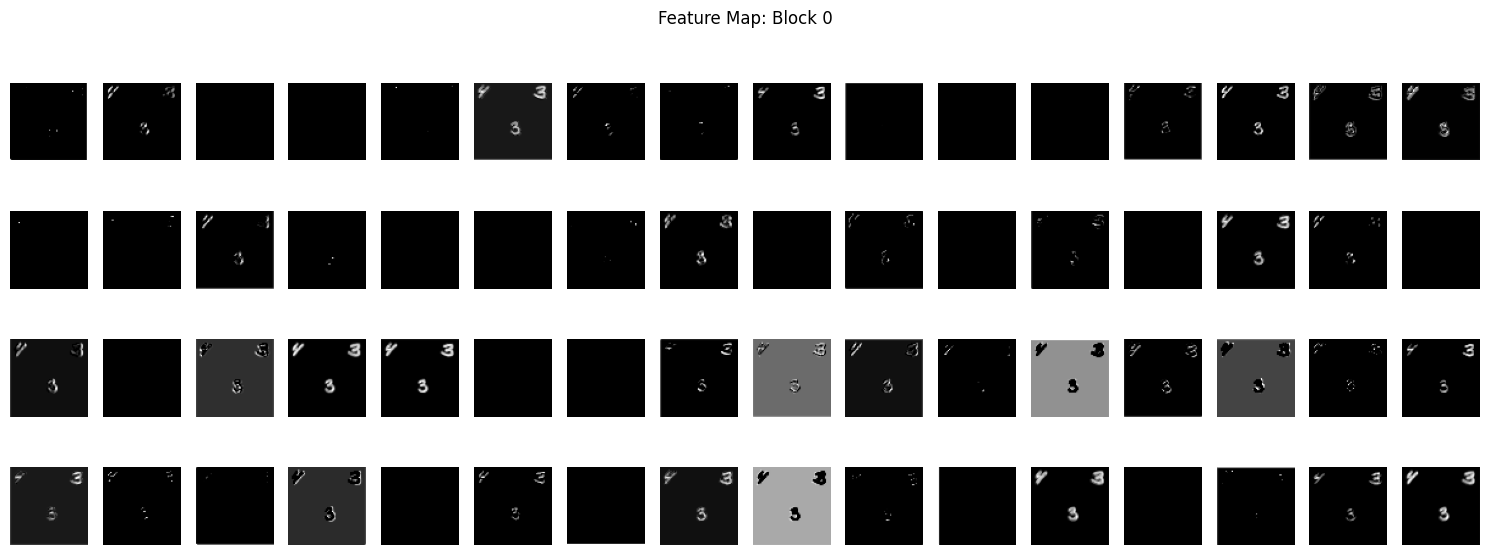

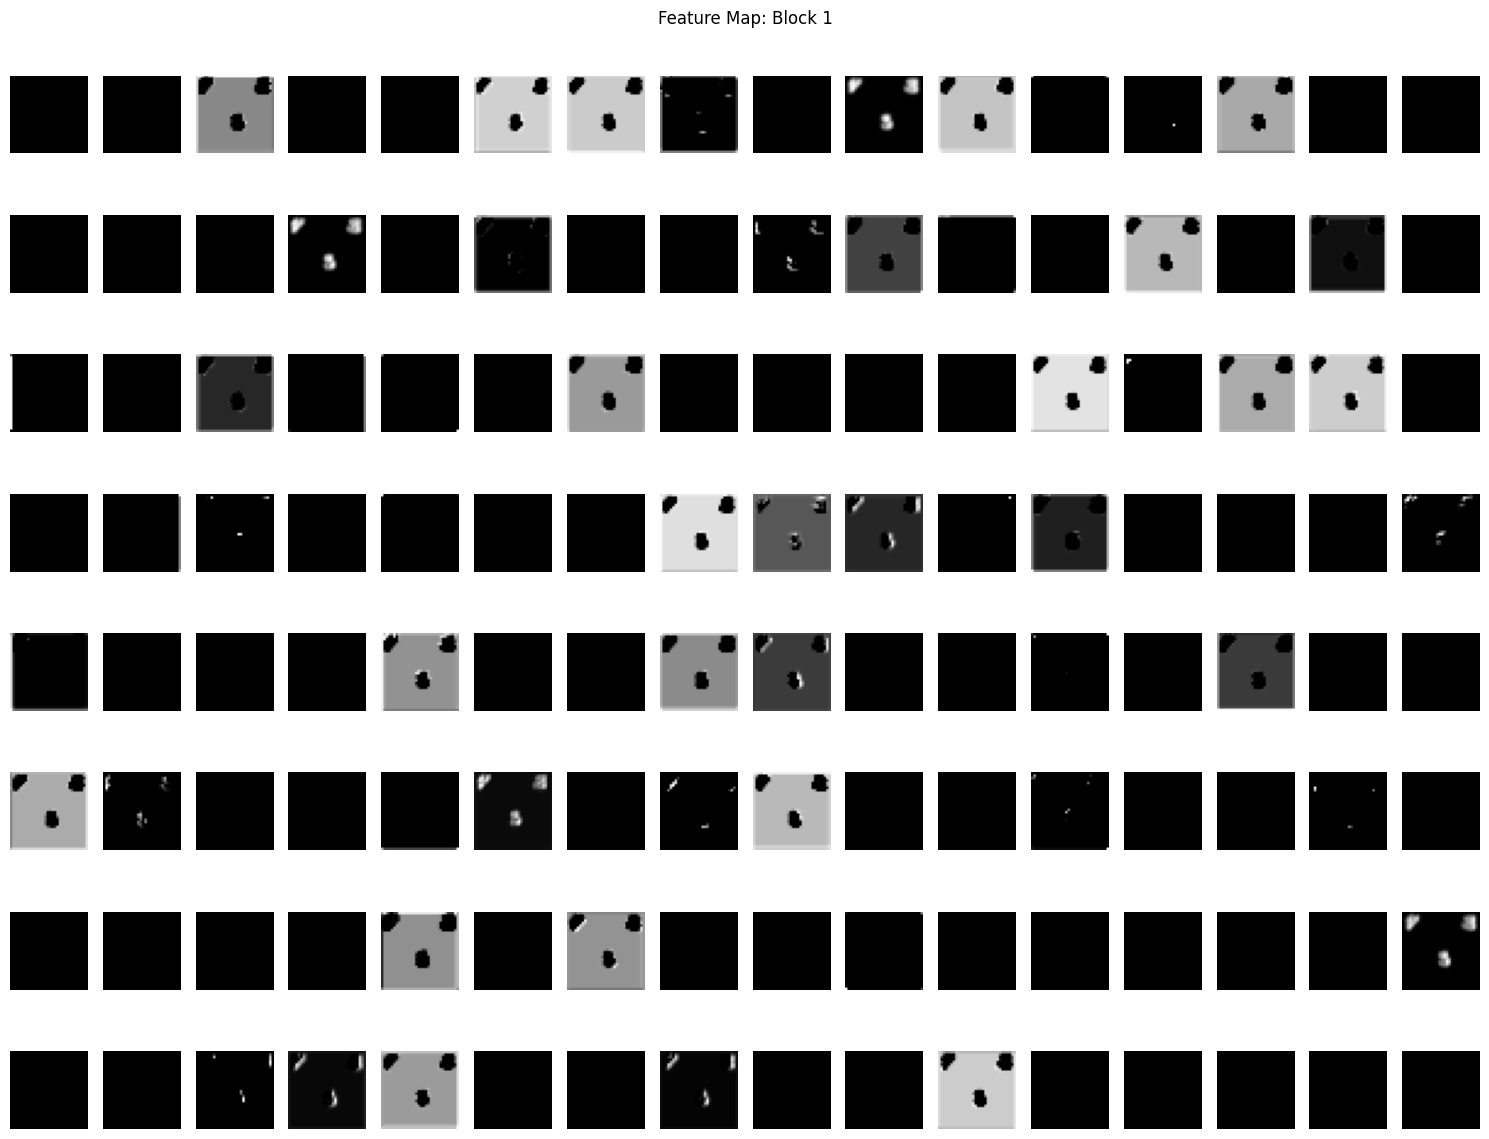

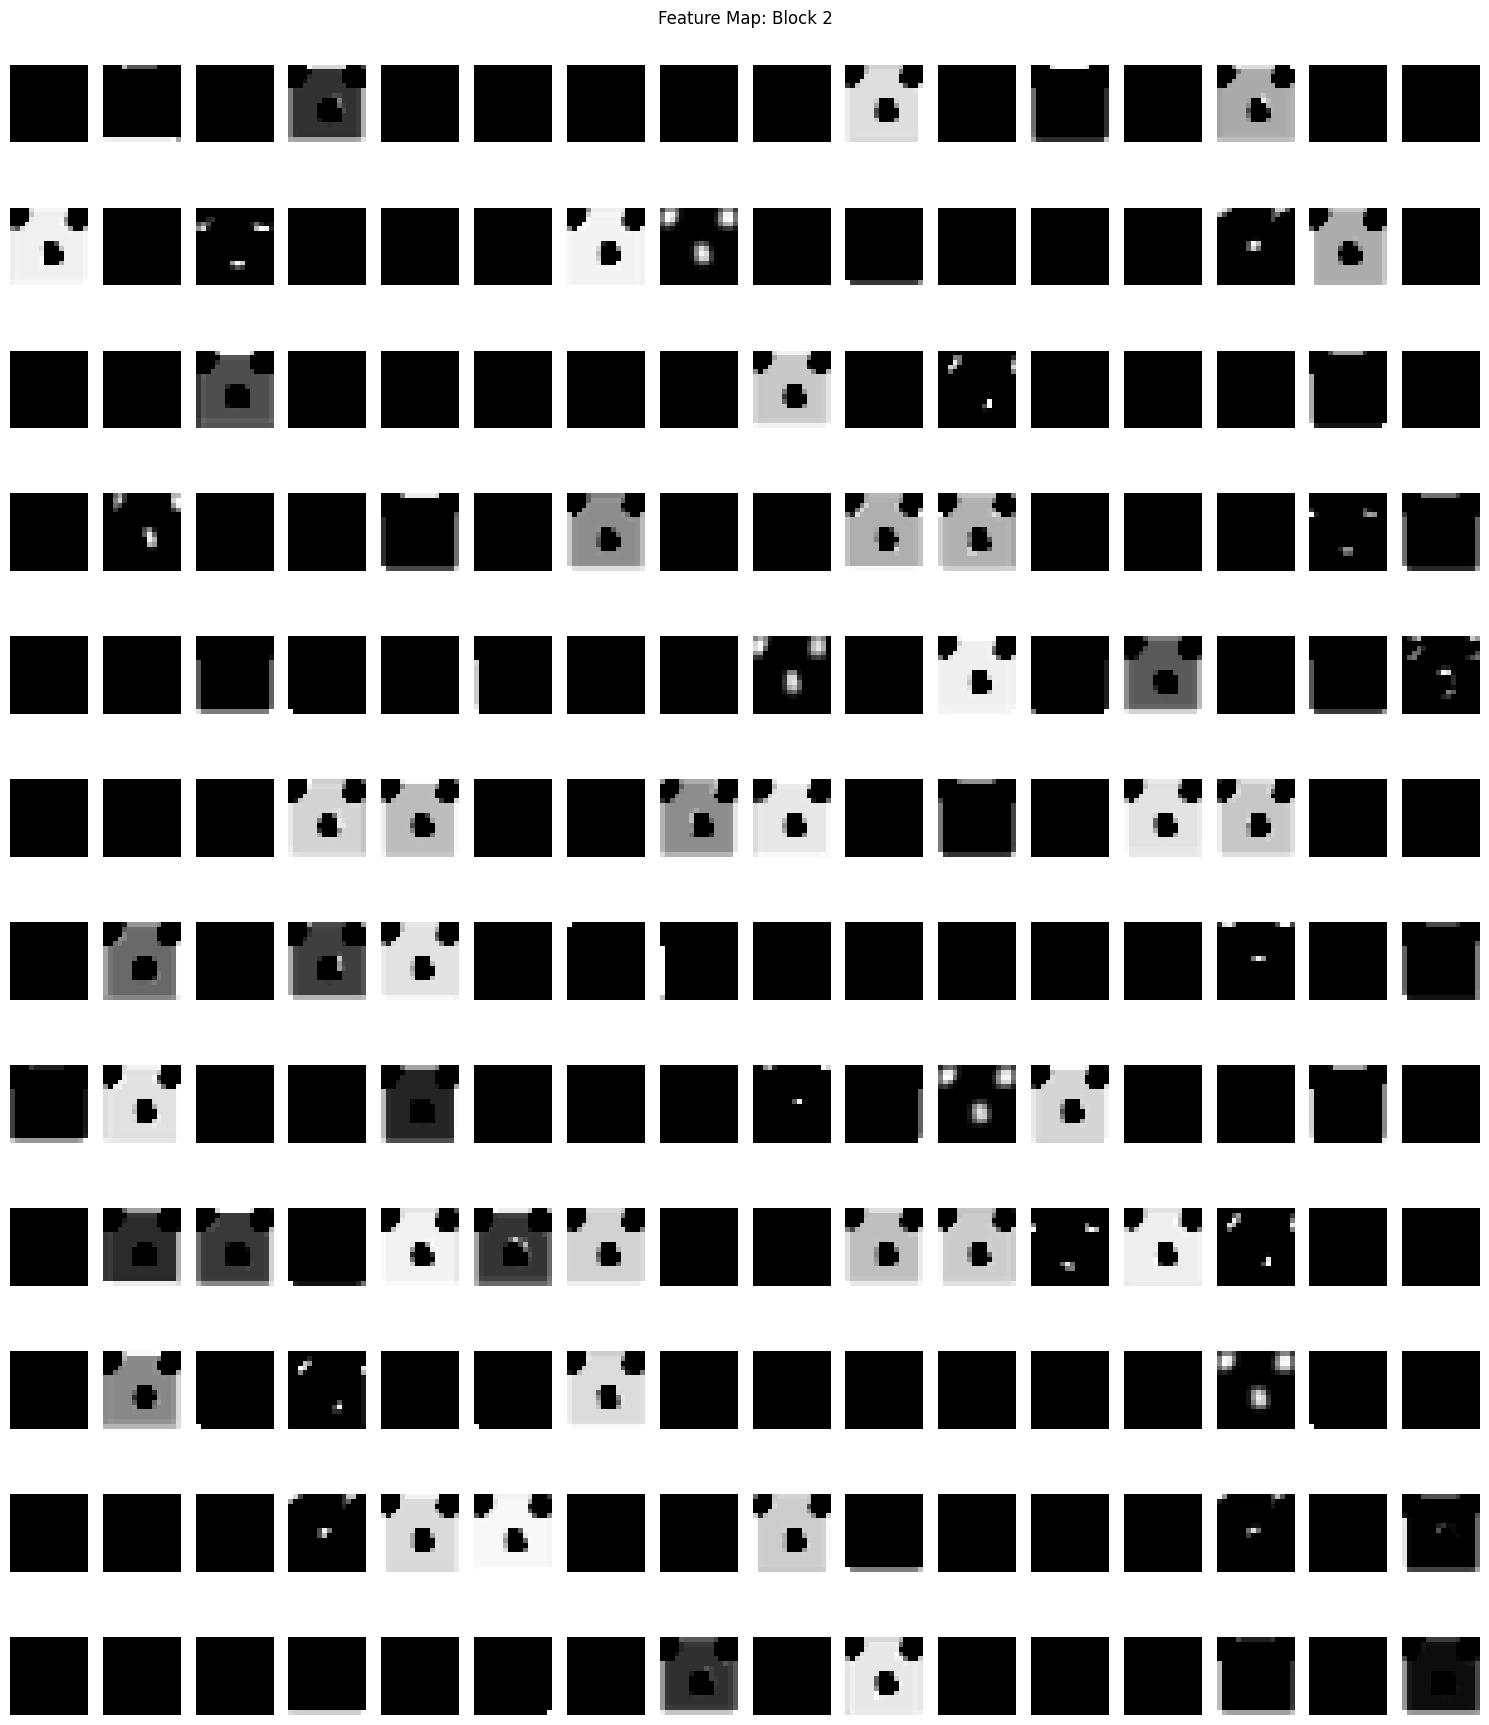

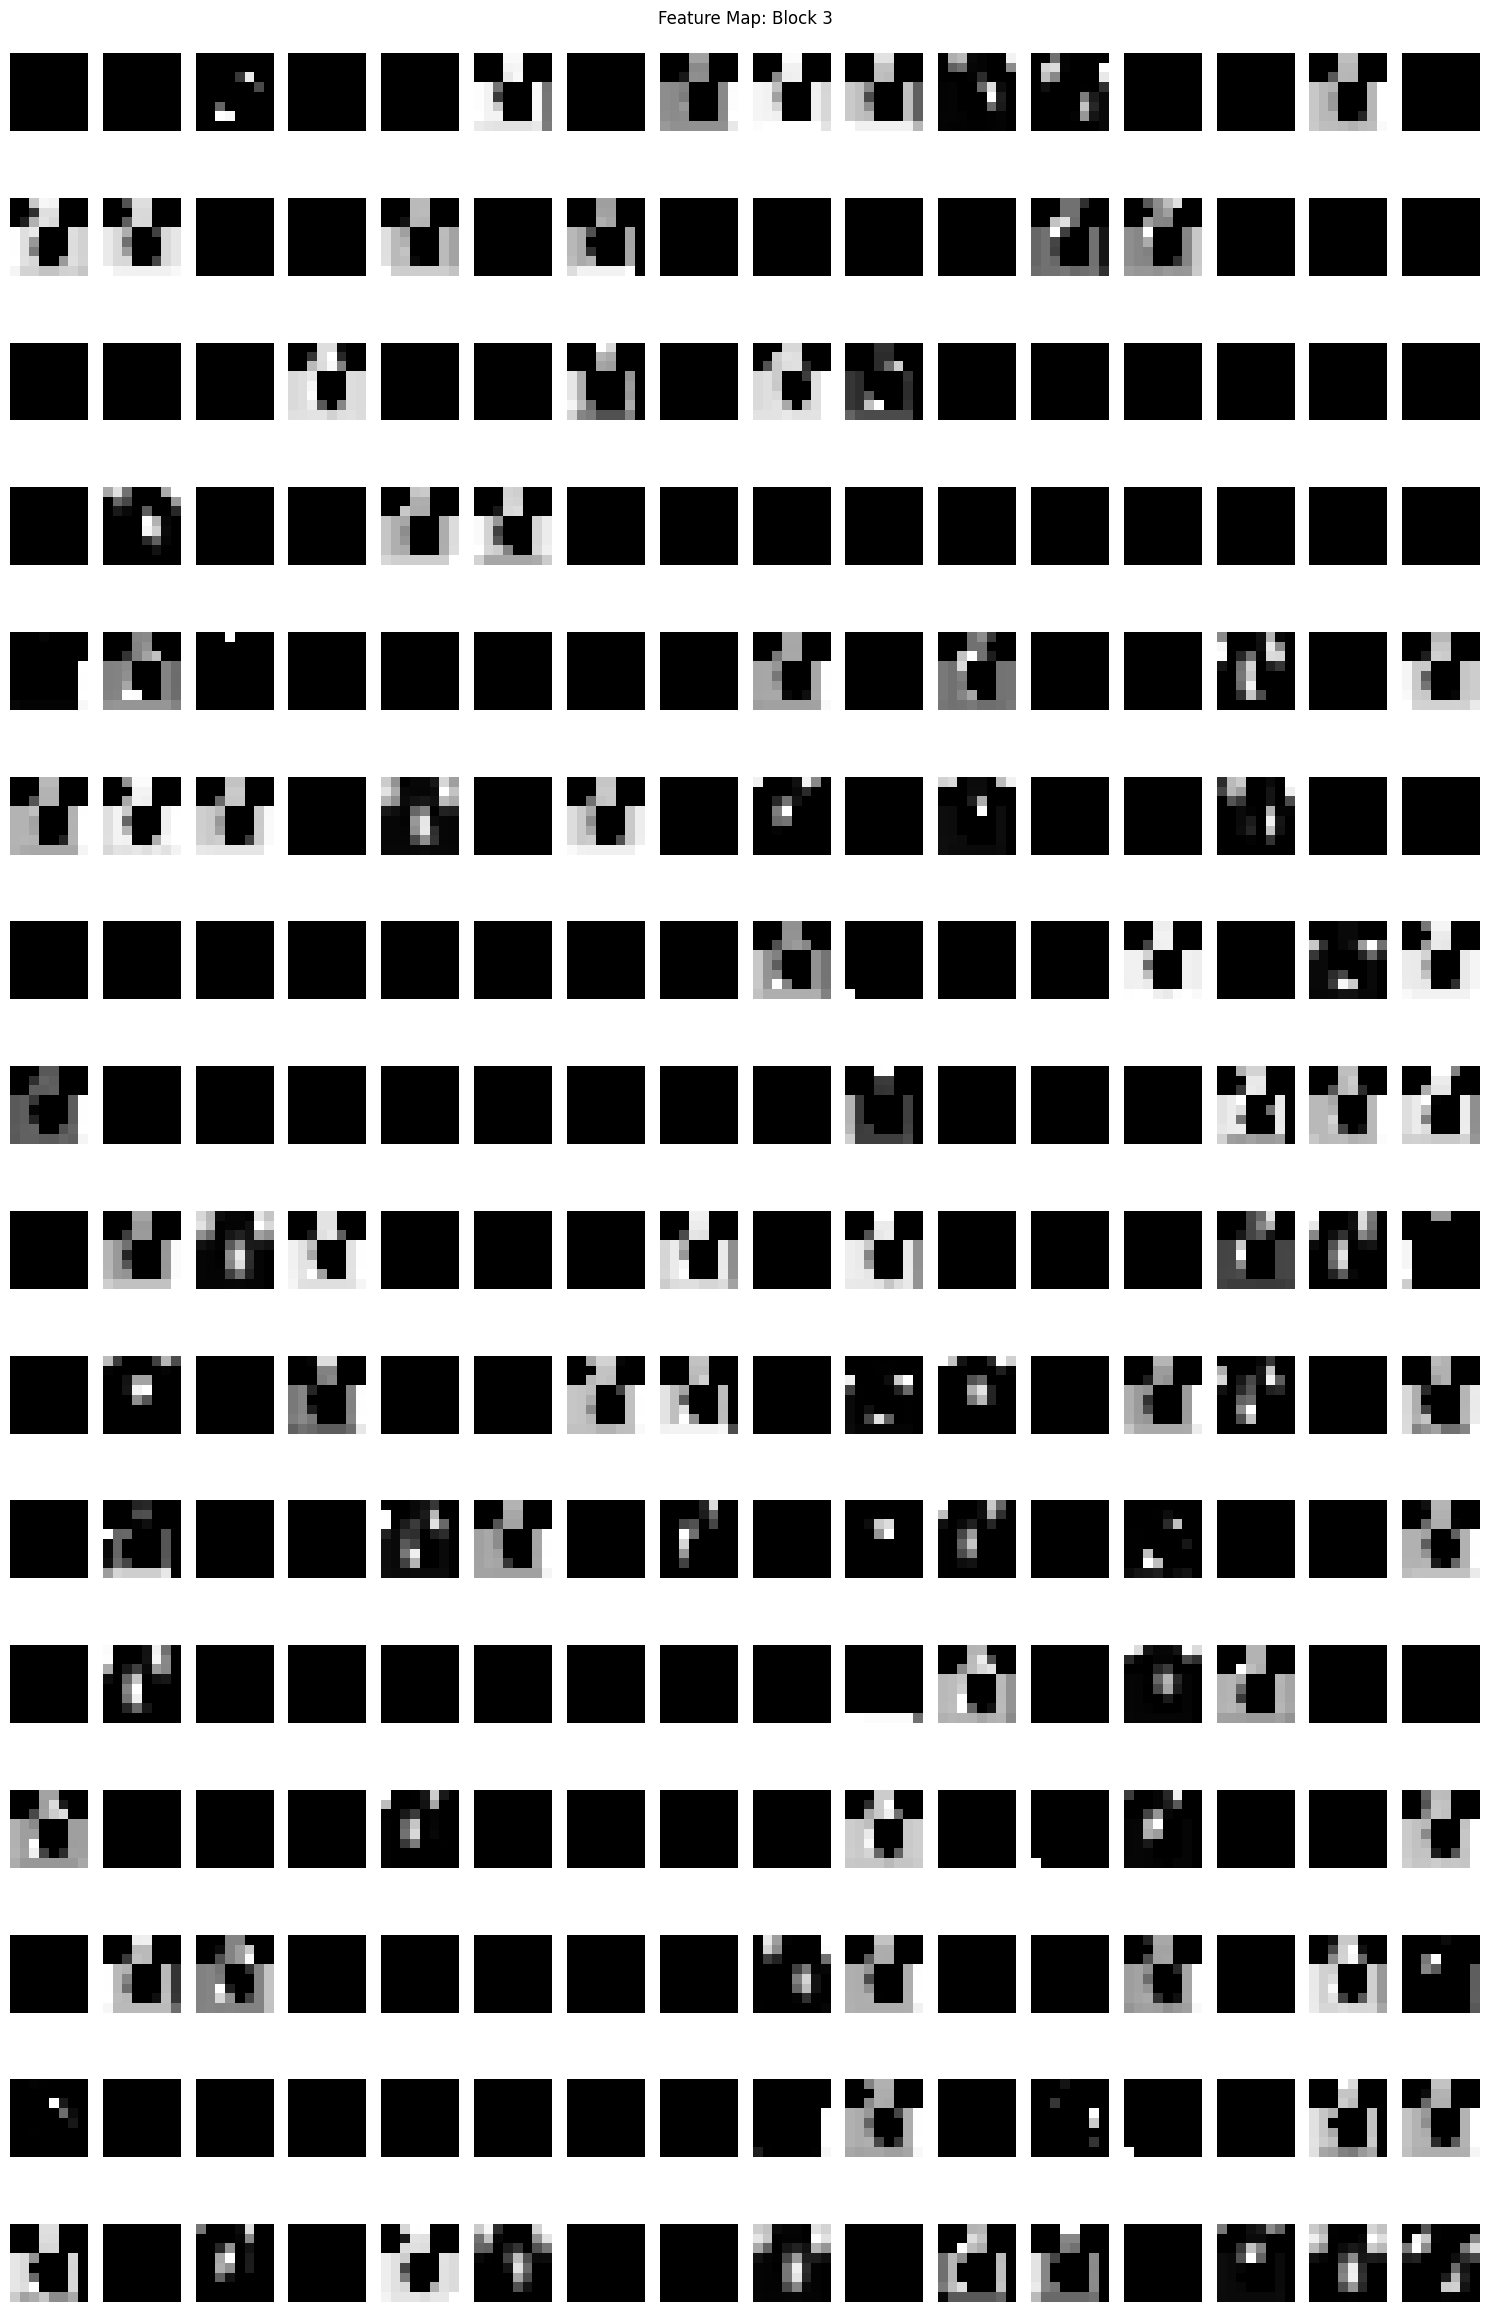

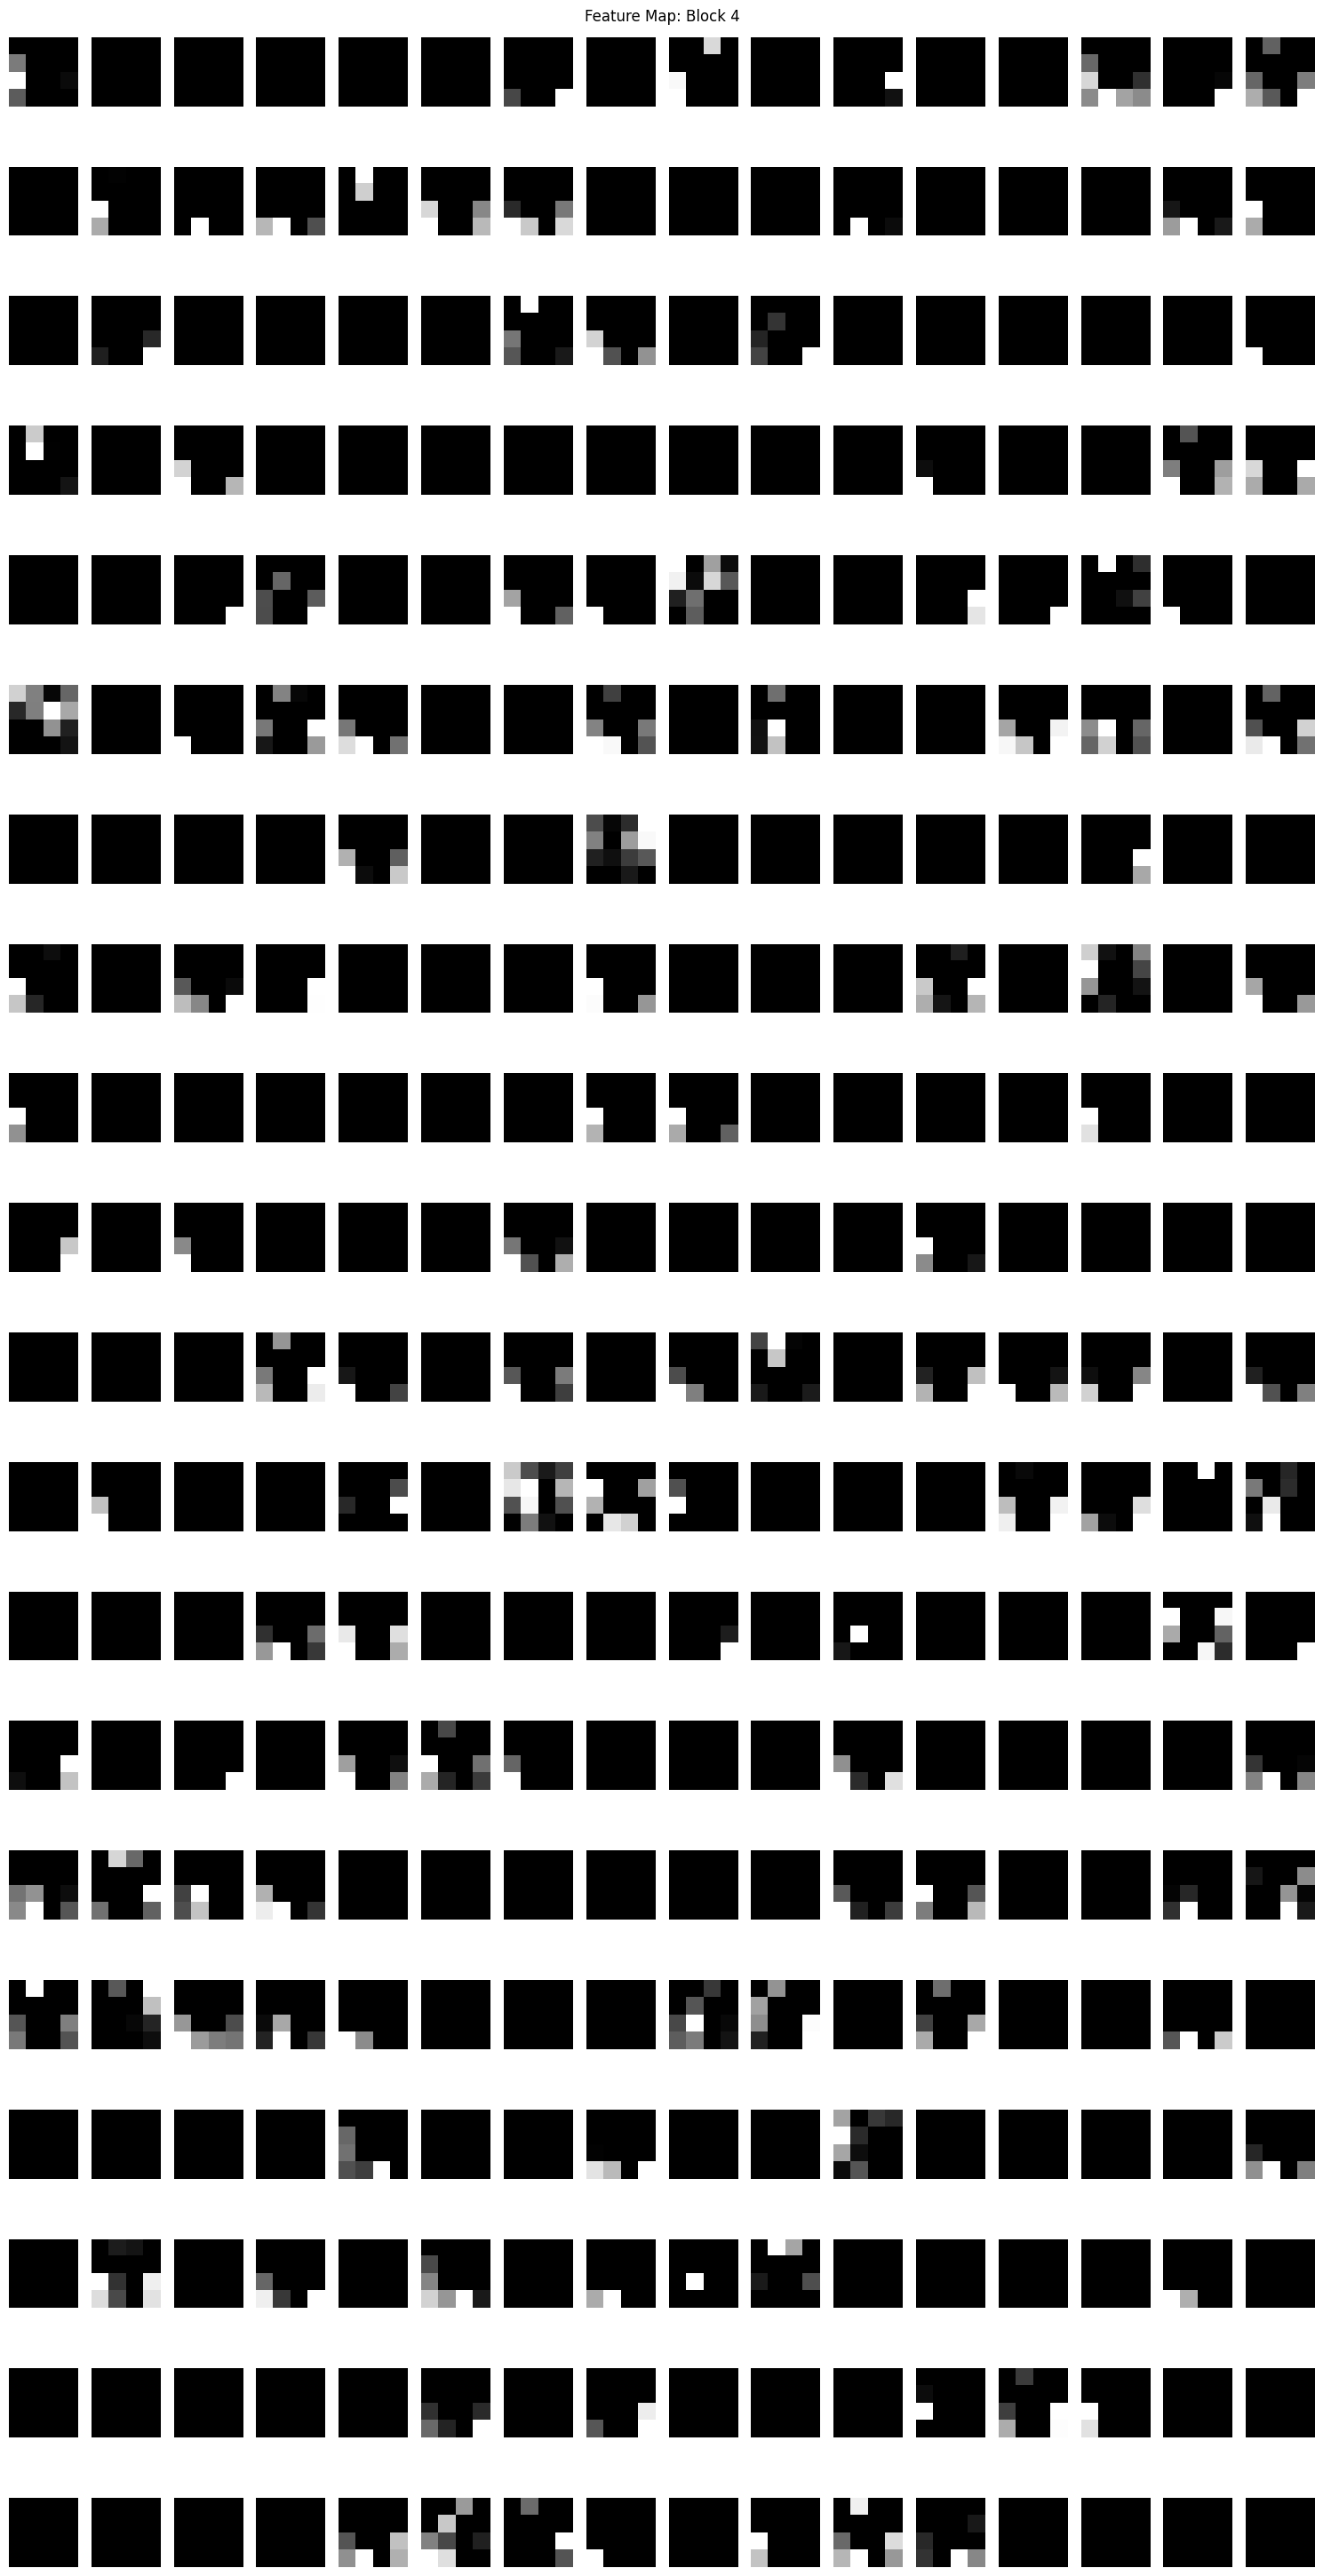

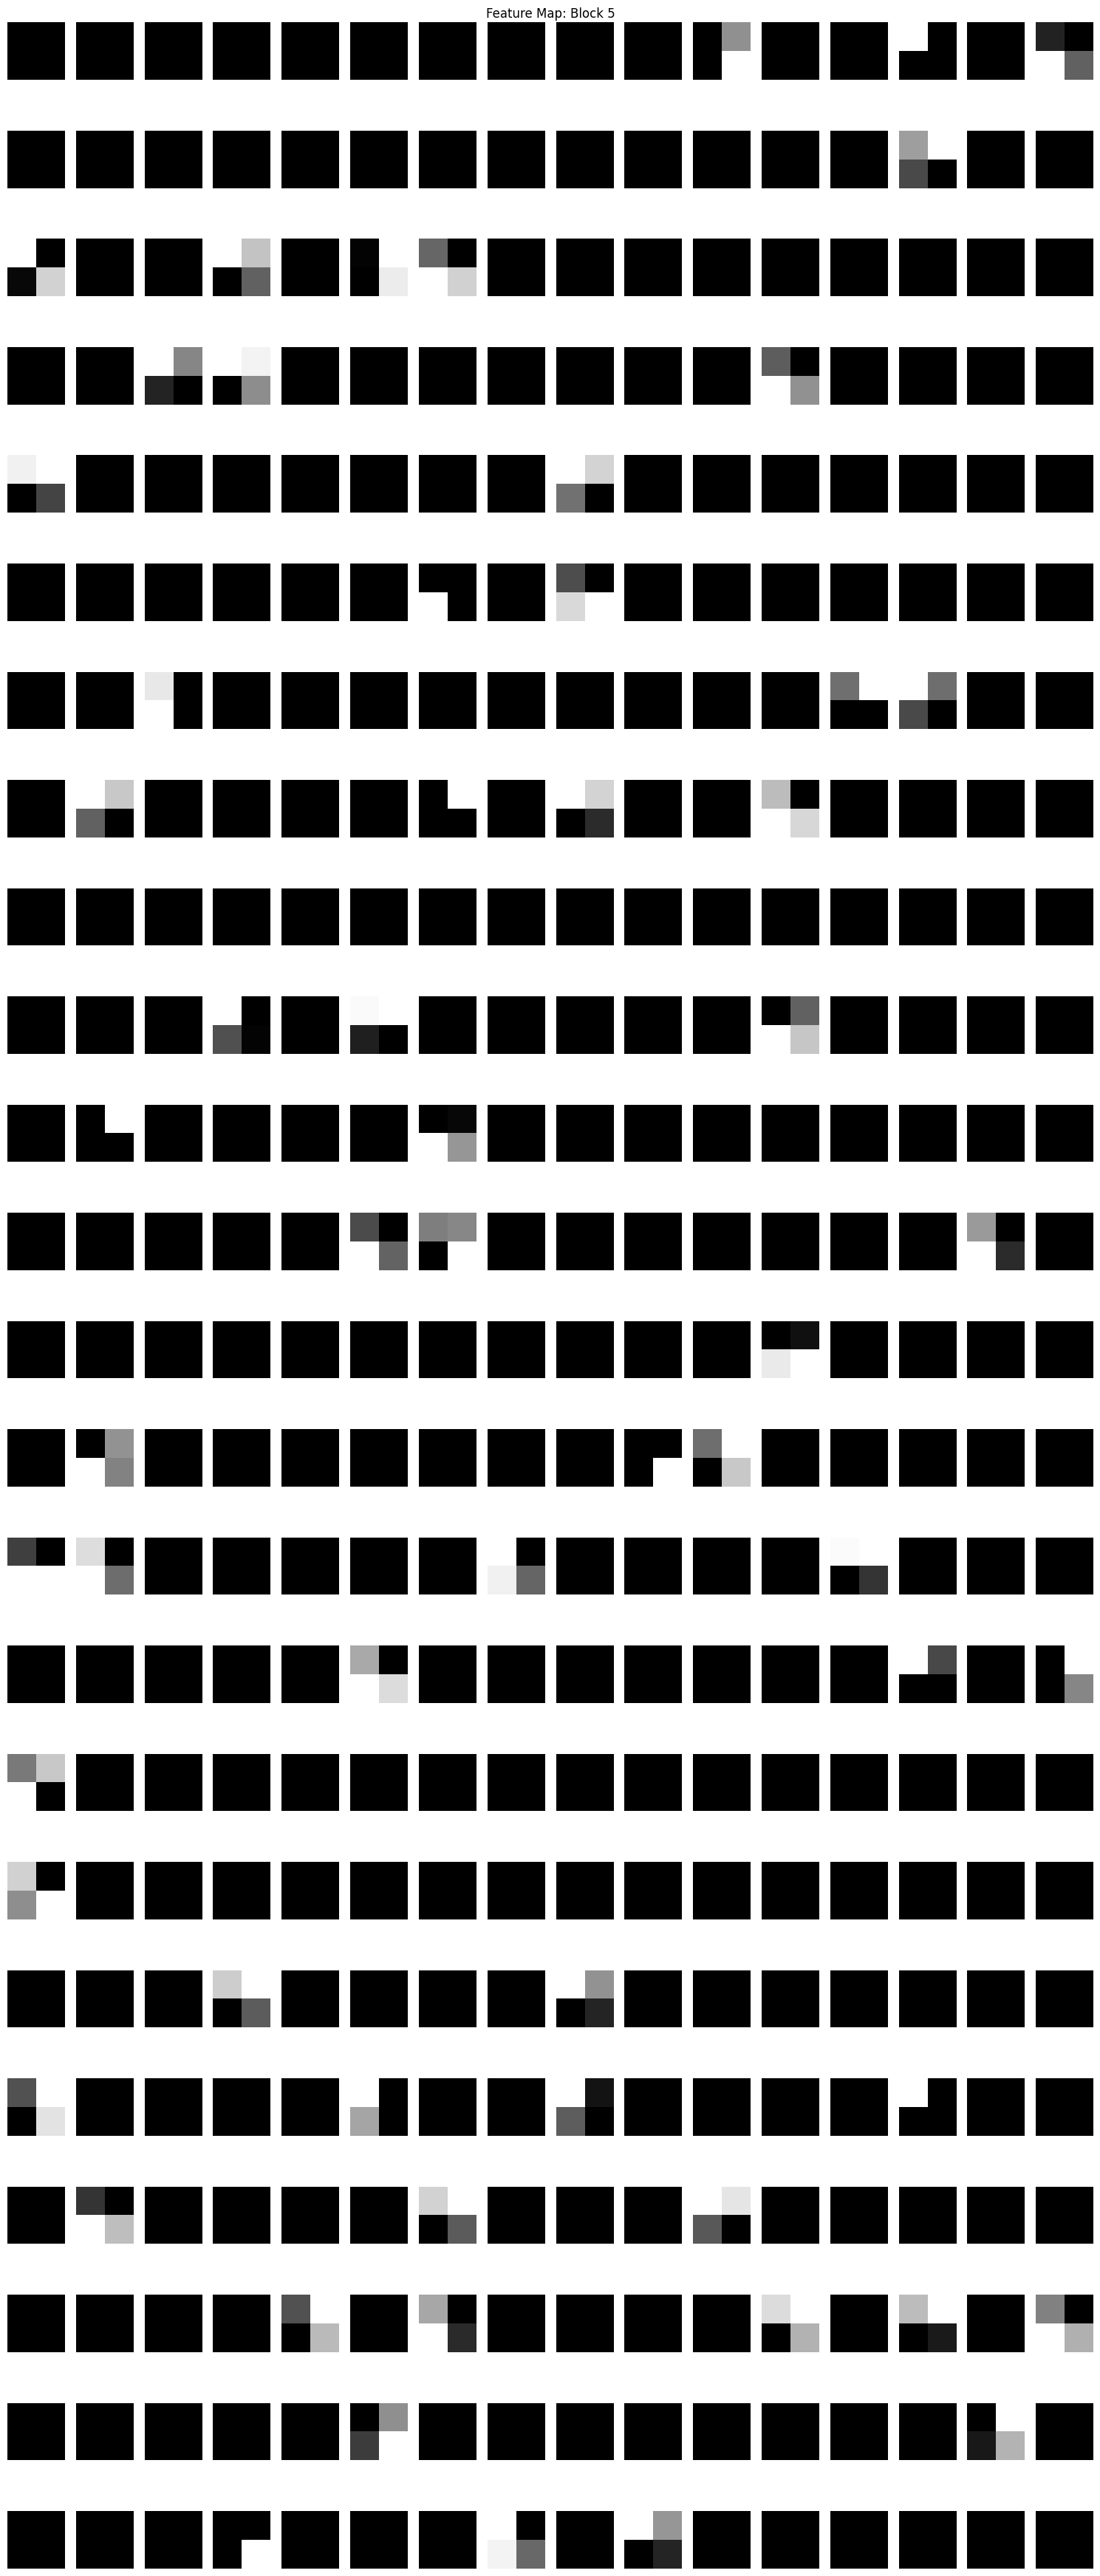

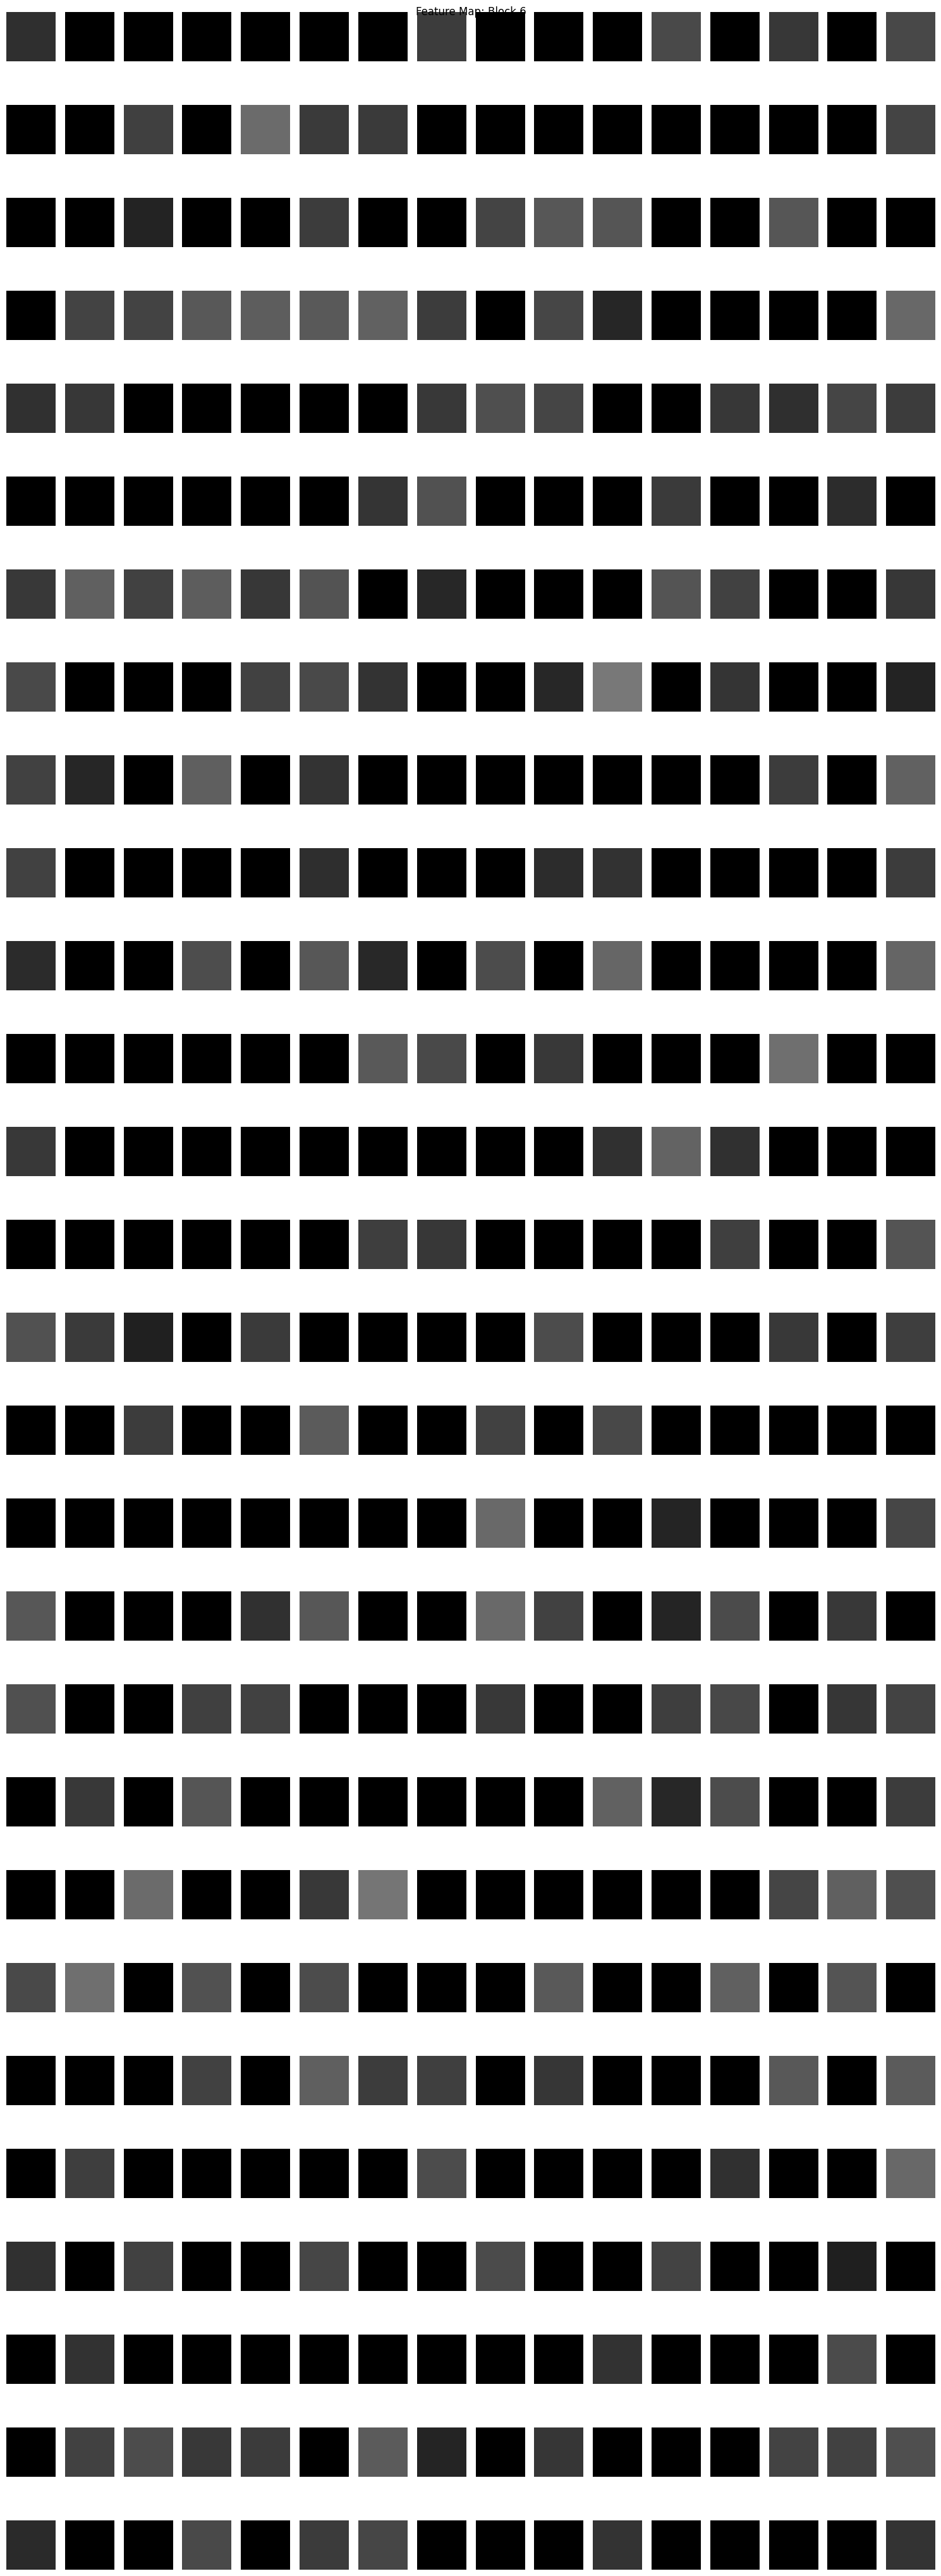

In [65]:
visualize_feature_maps(feature_maps, image_idx=0, num_blocks=regression_cnn.num_blocks)

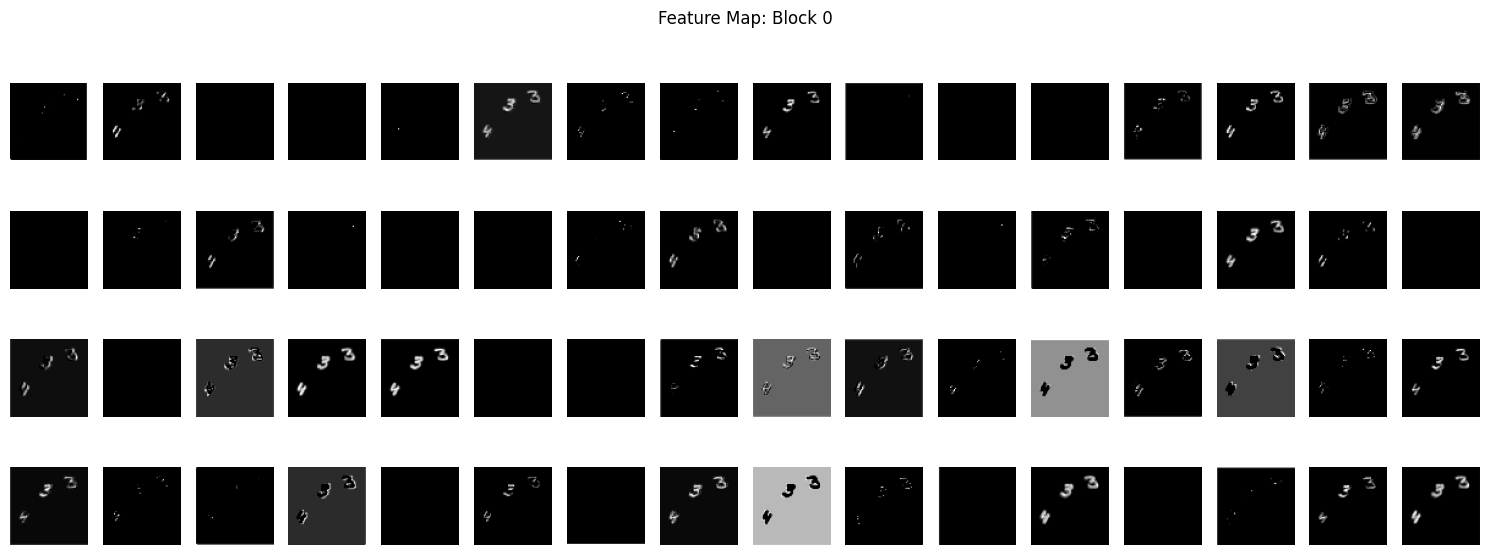

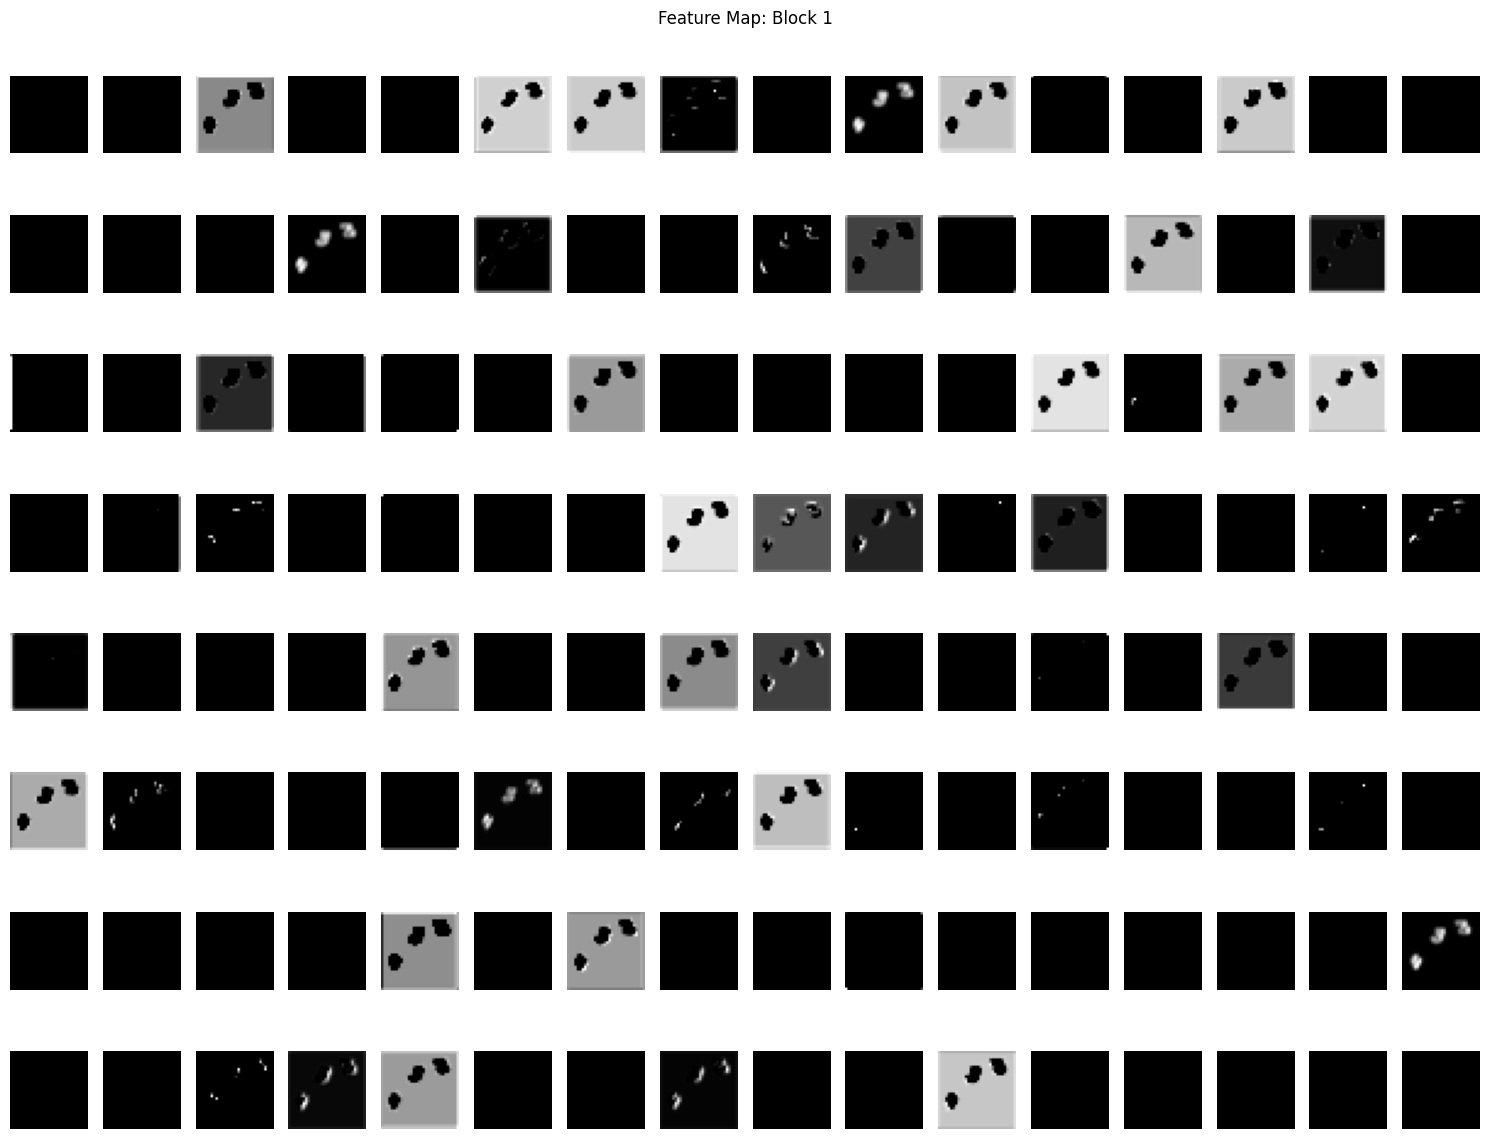

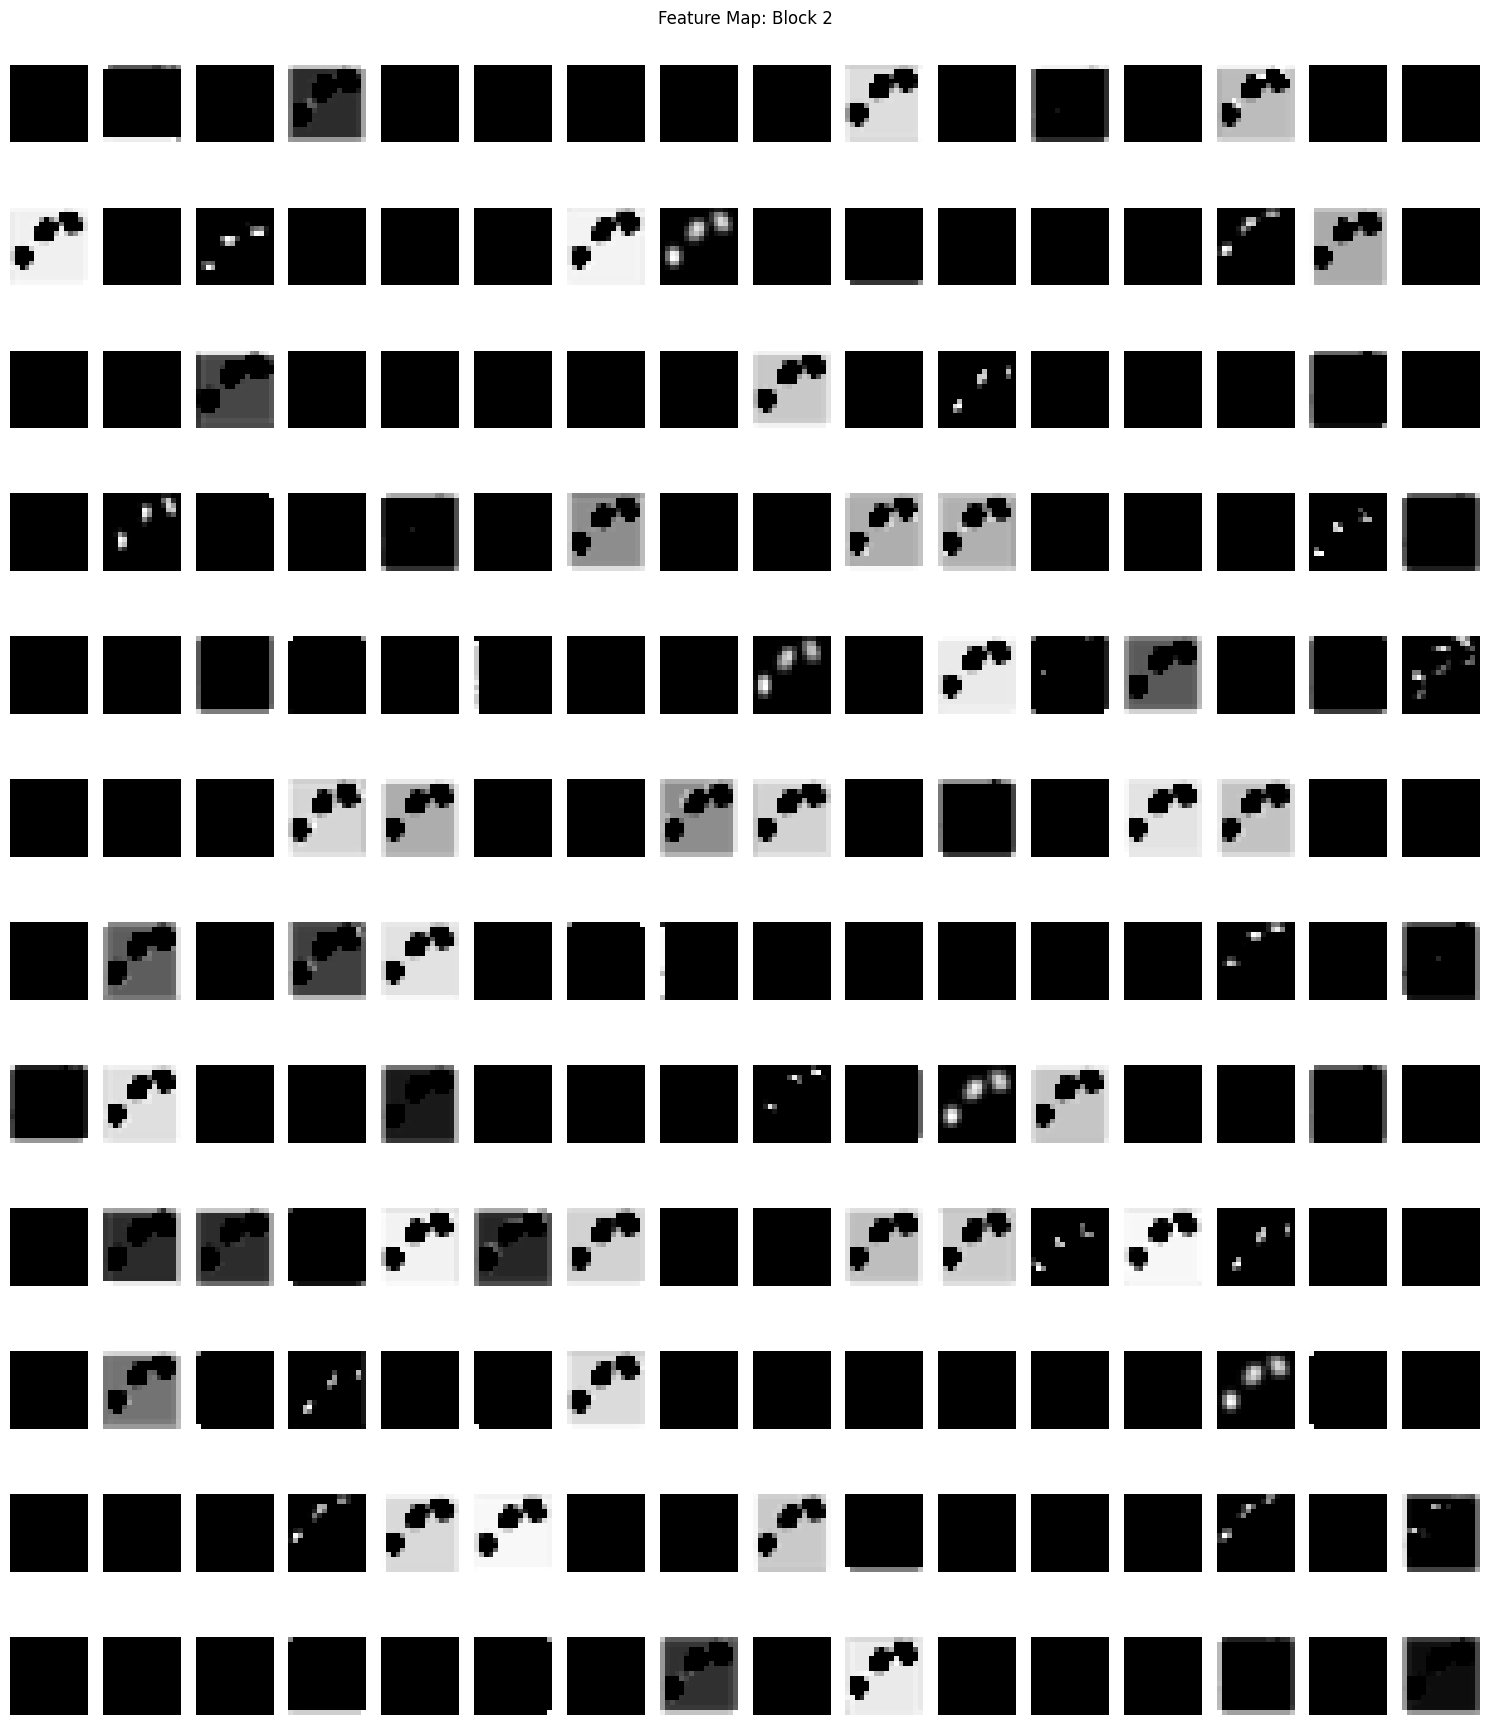

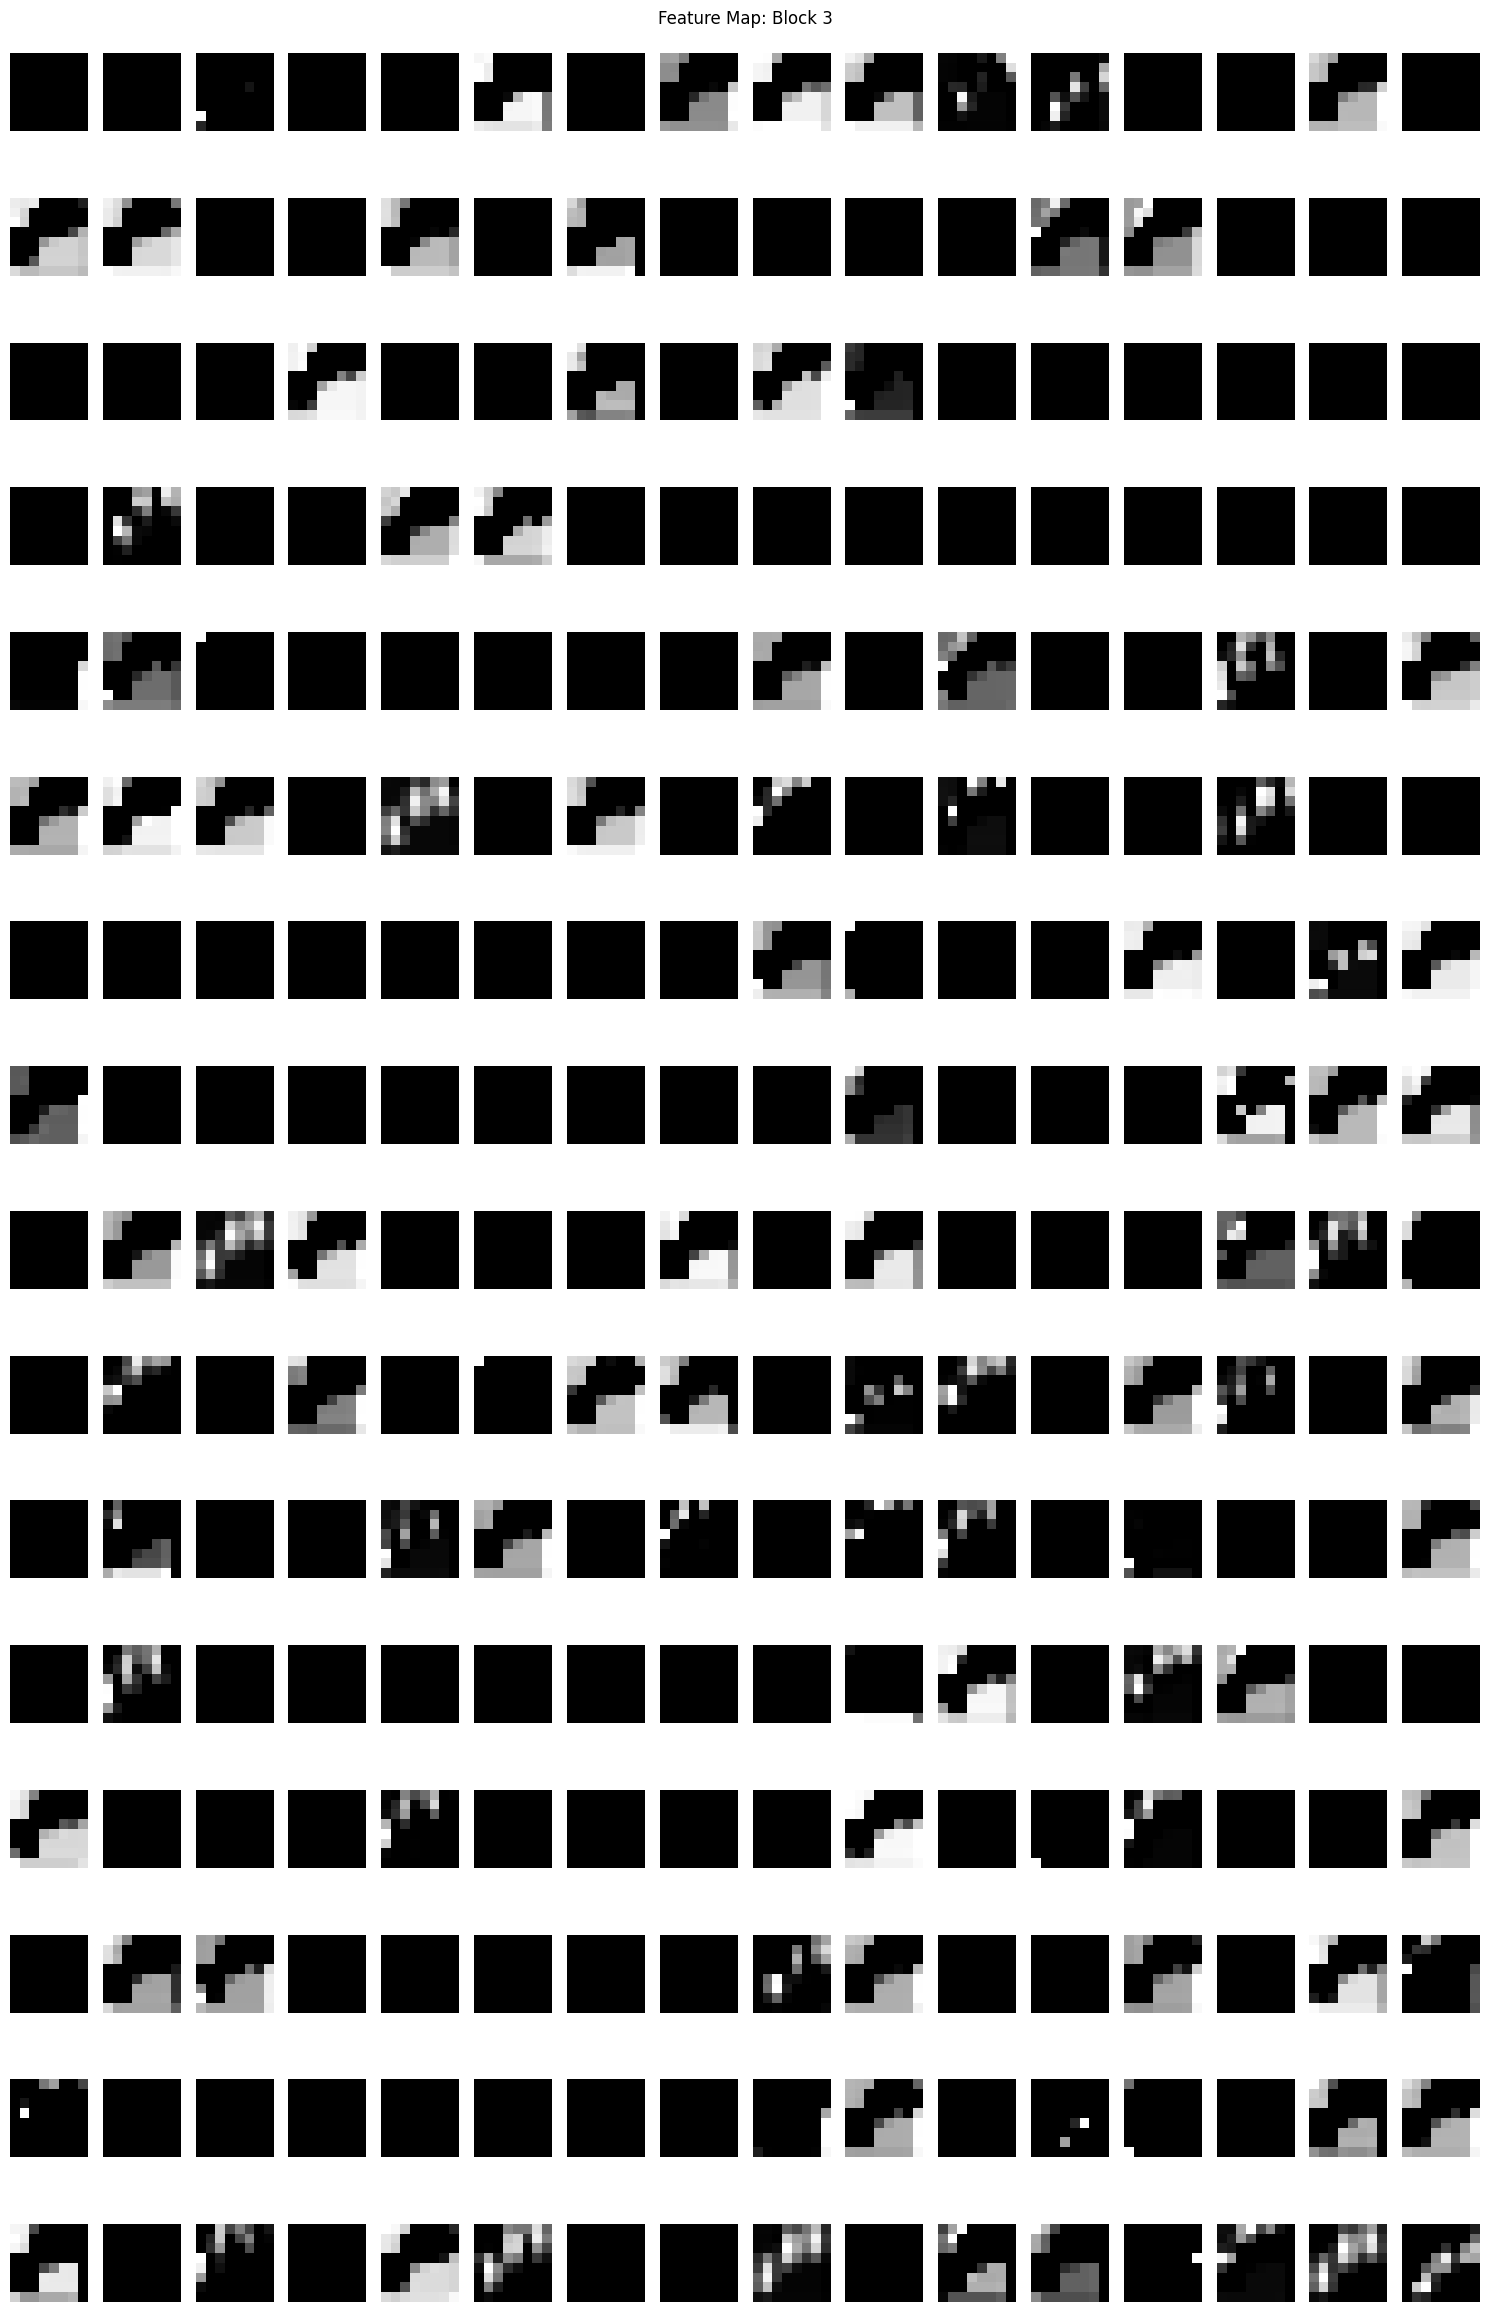

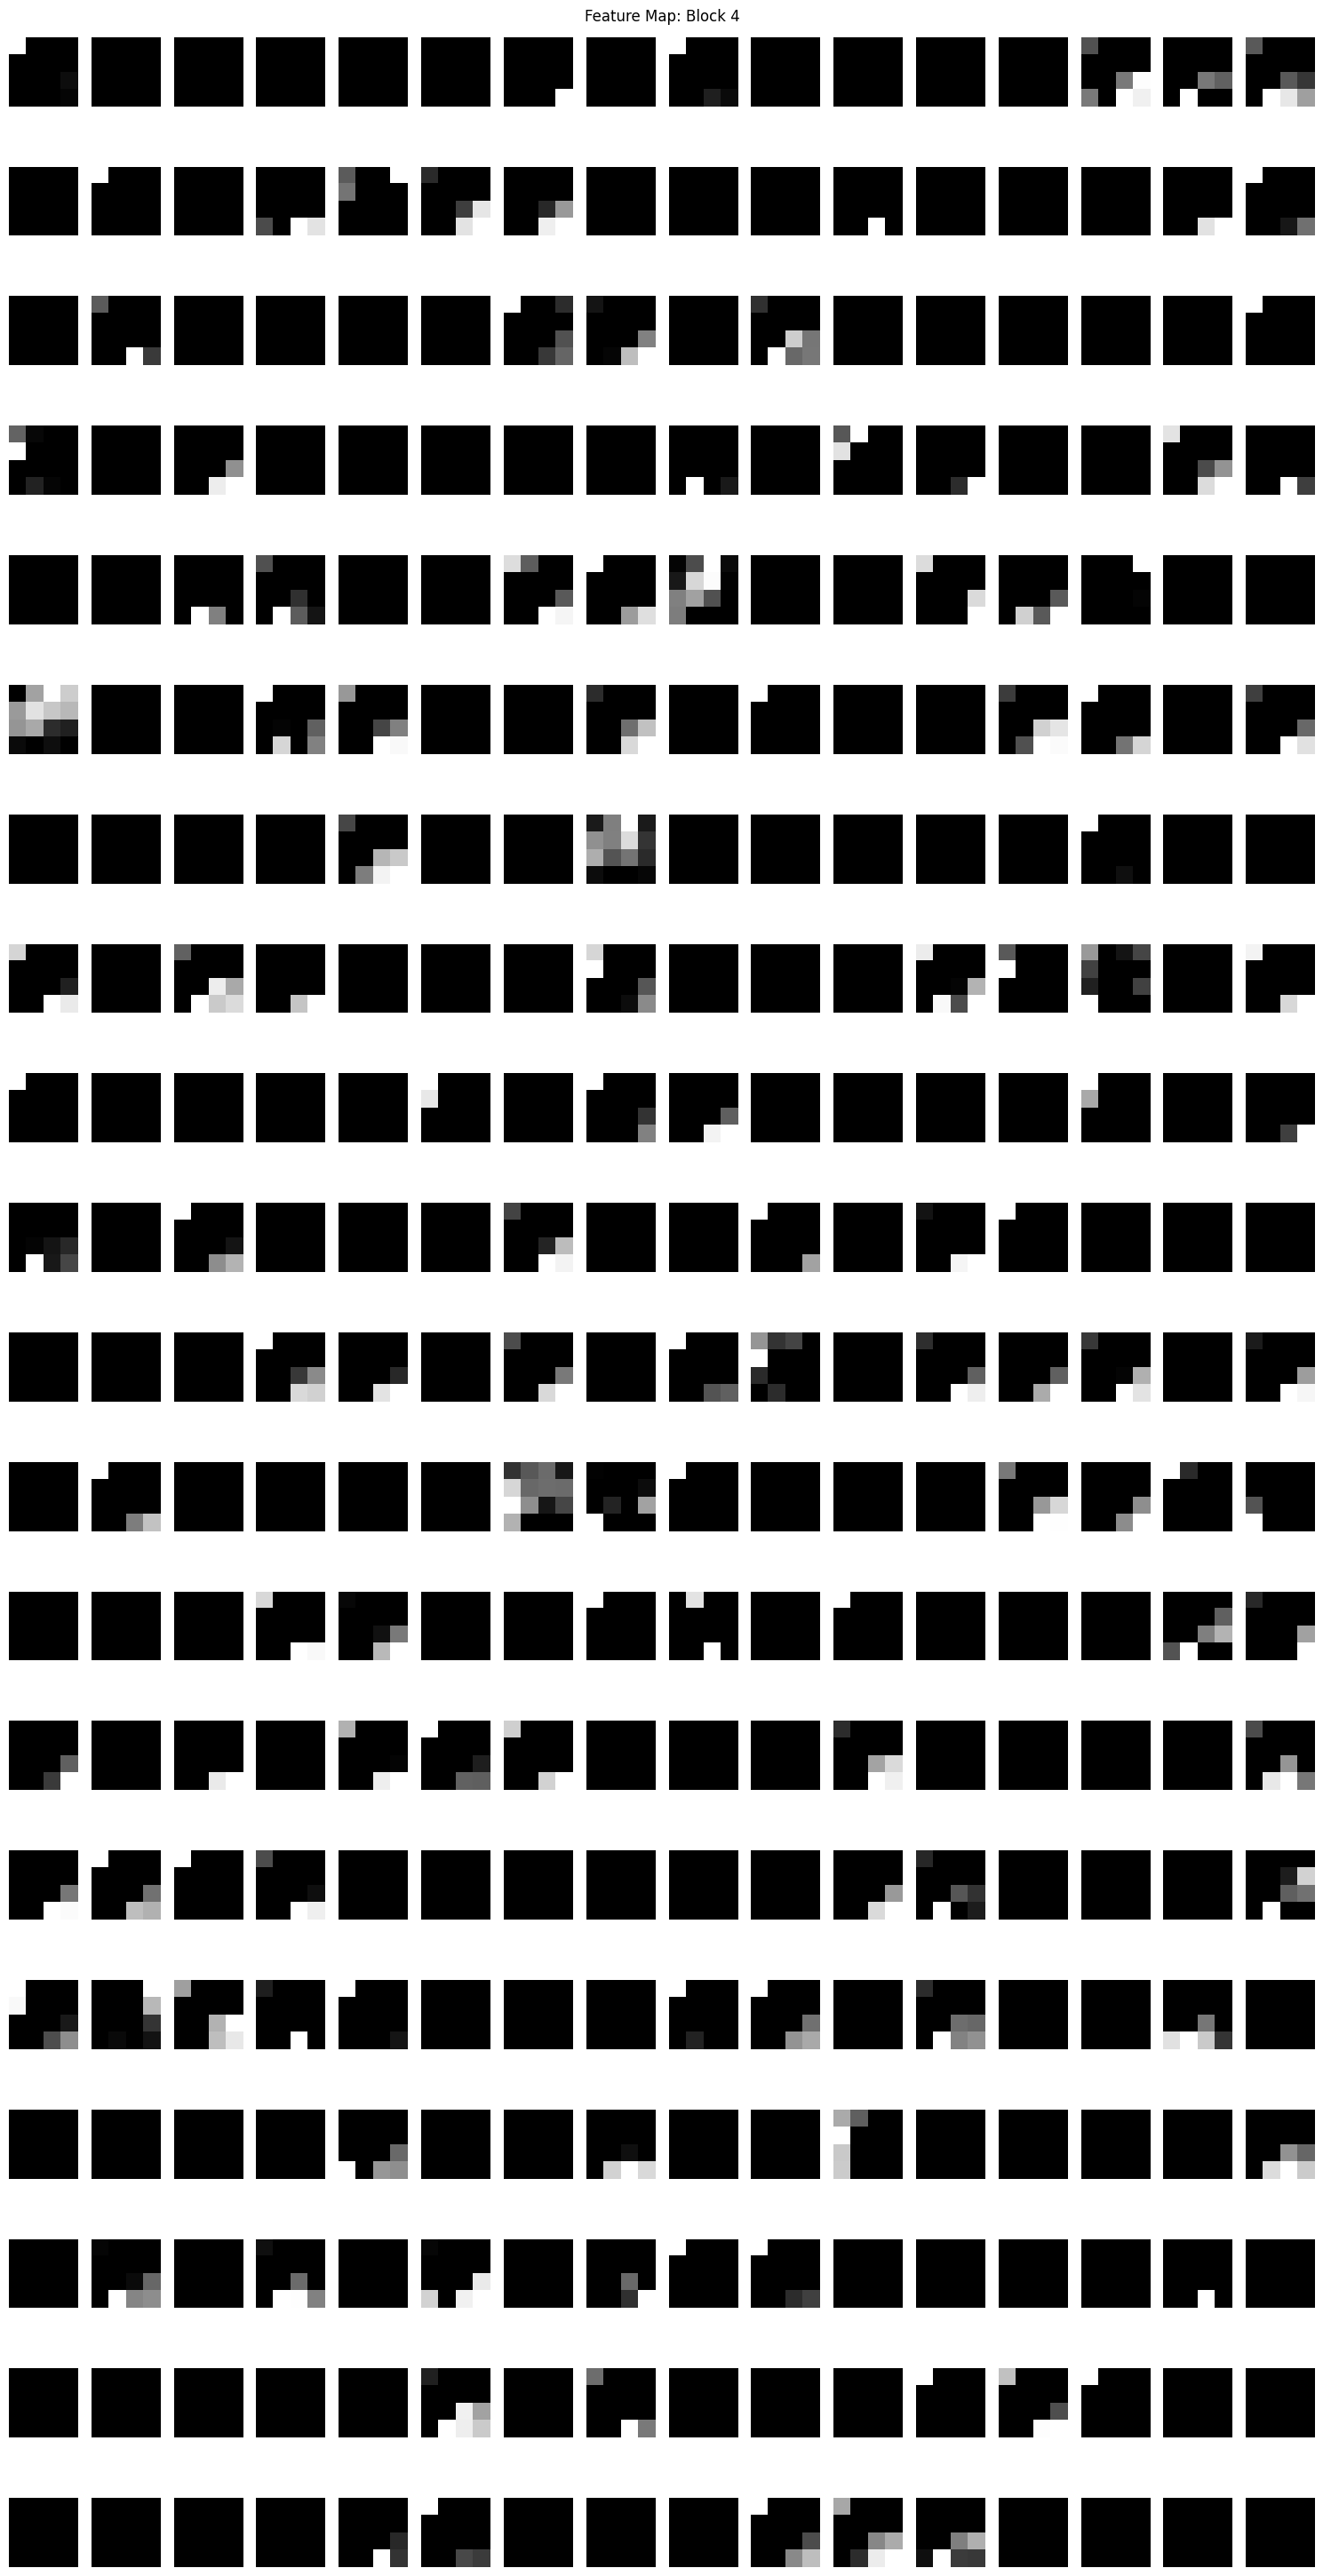

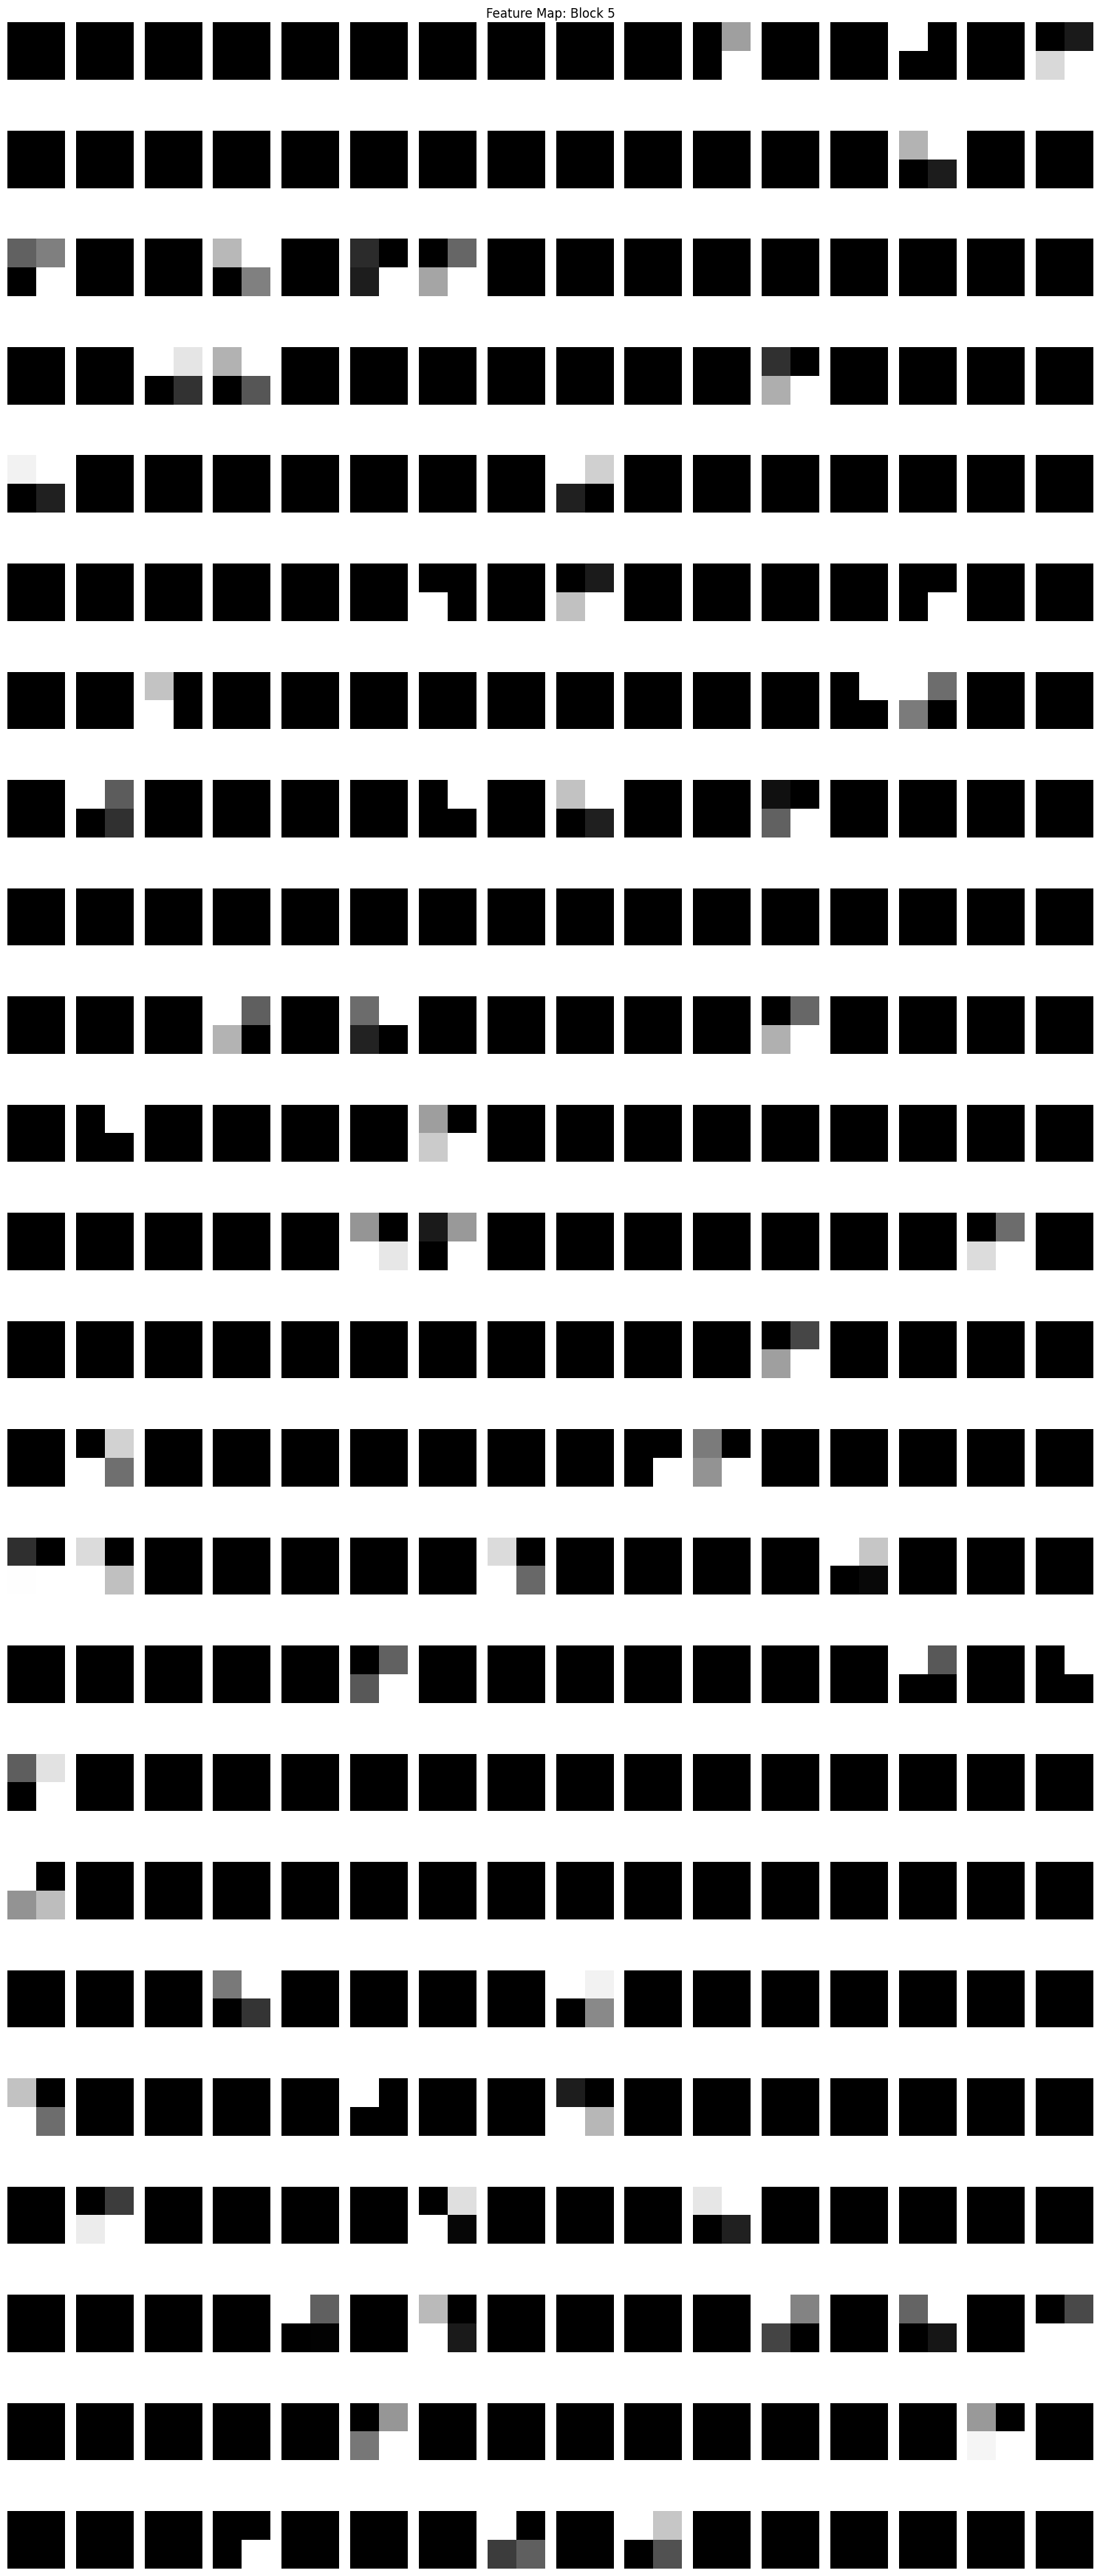

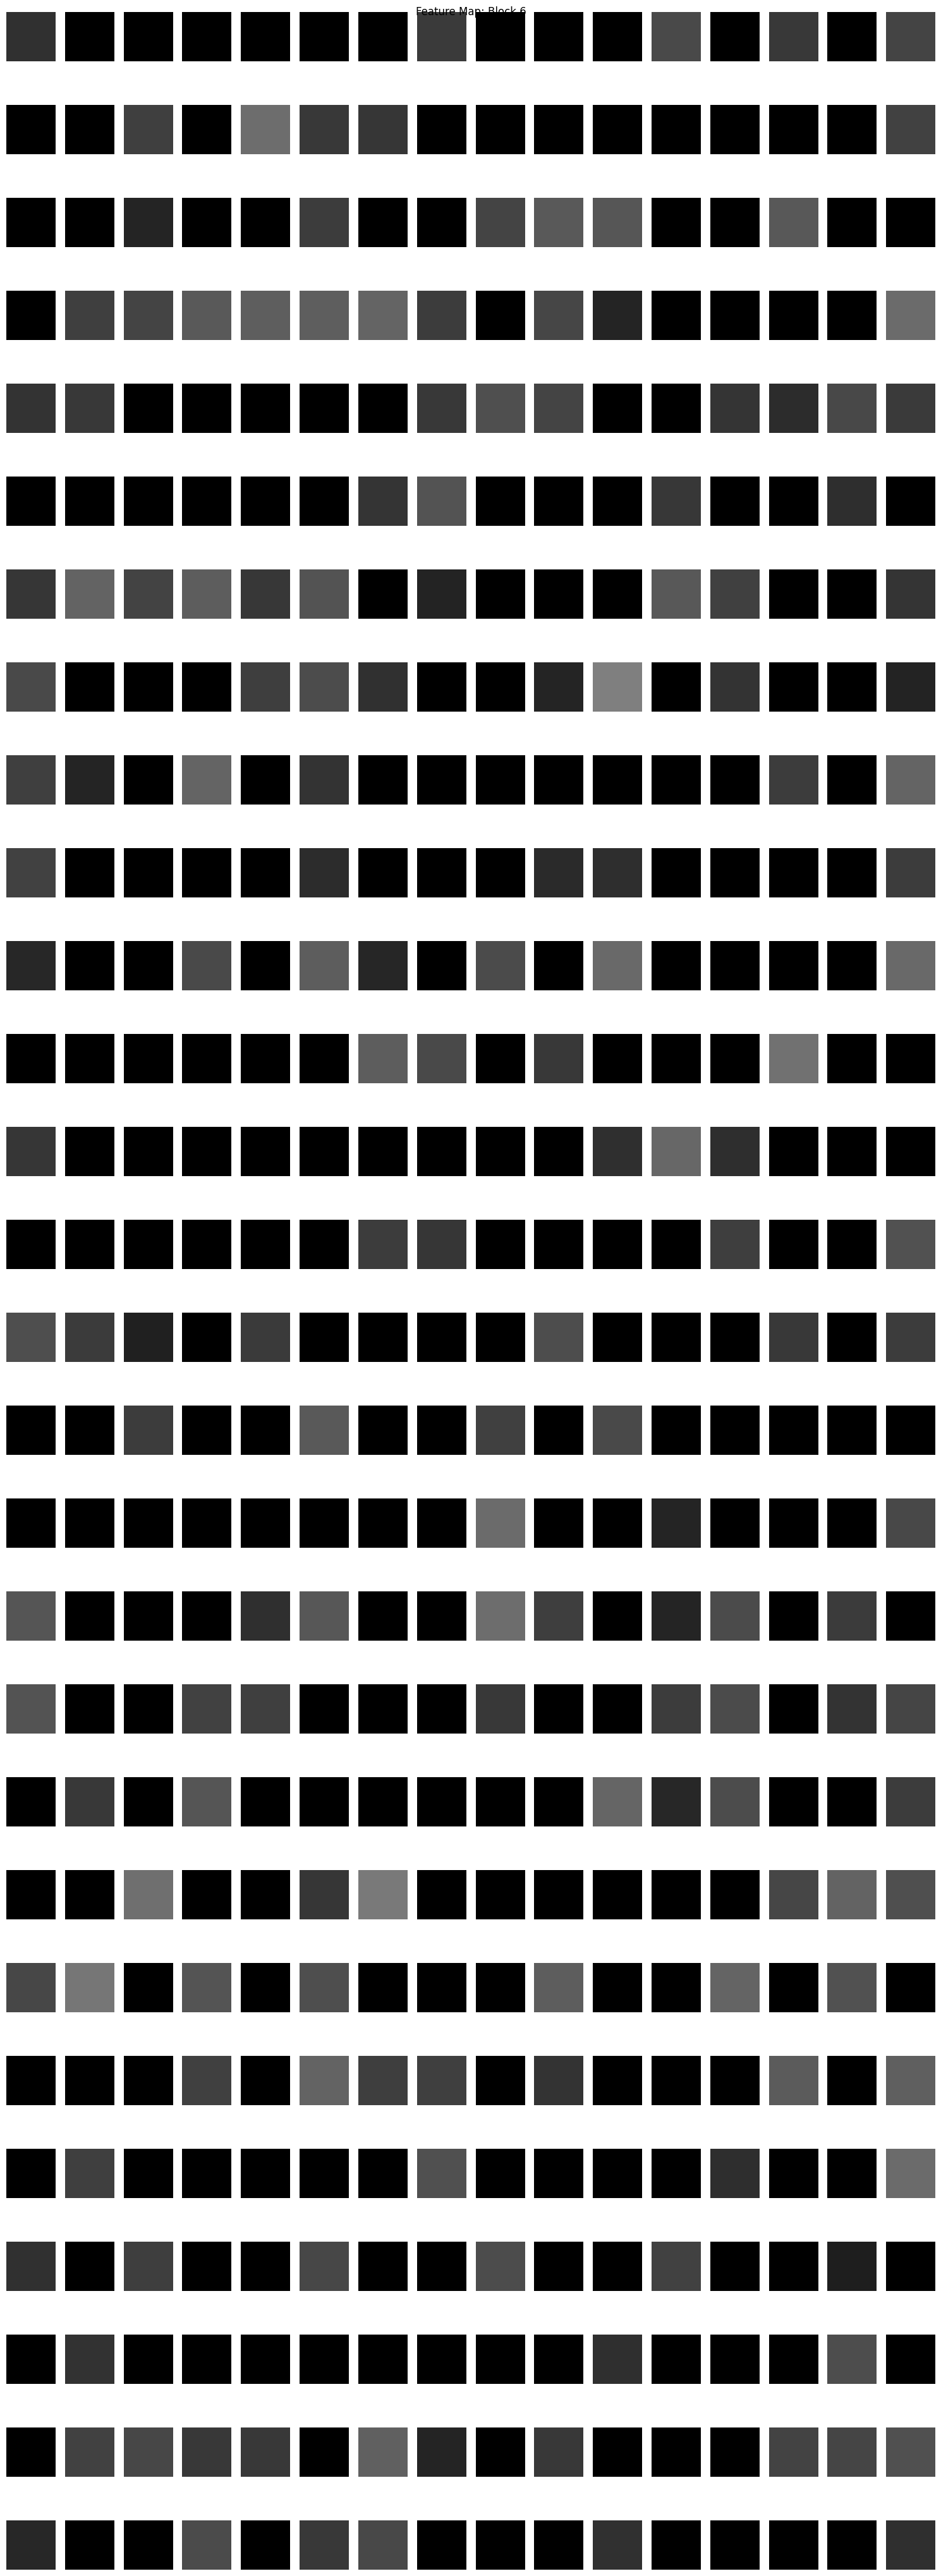

In [66]:
visualize_feature_maps(feature_maps, image_idx=1, num_blocks=regression_cnn.num_blocks)

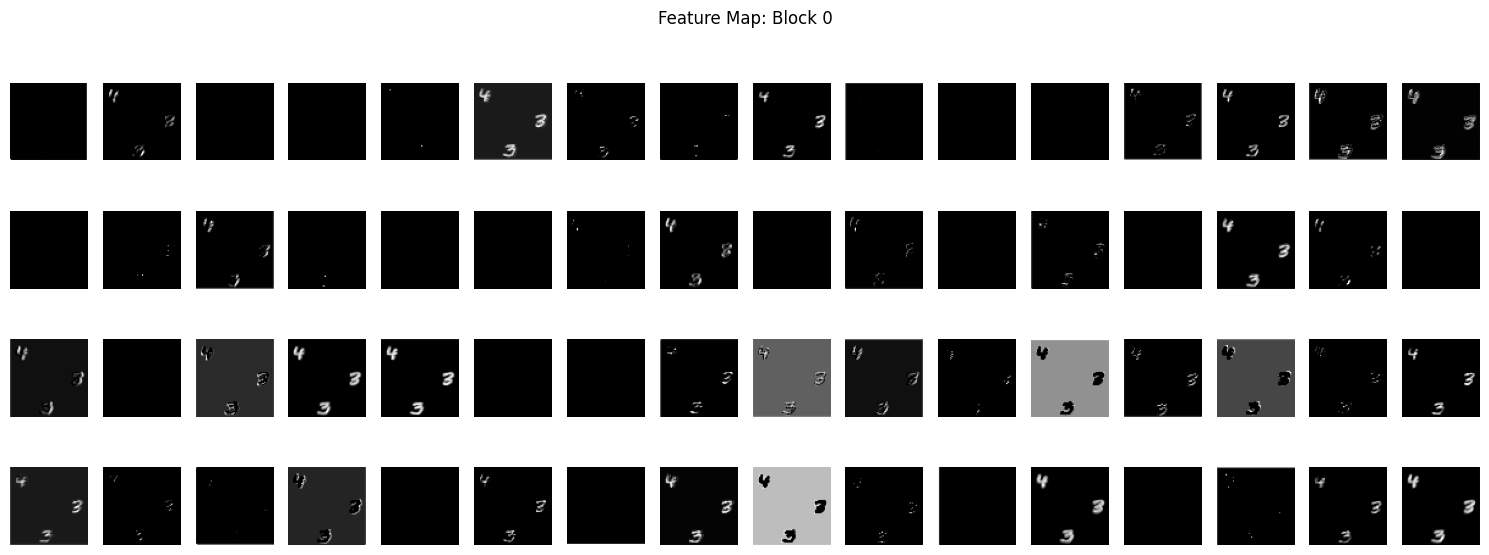

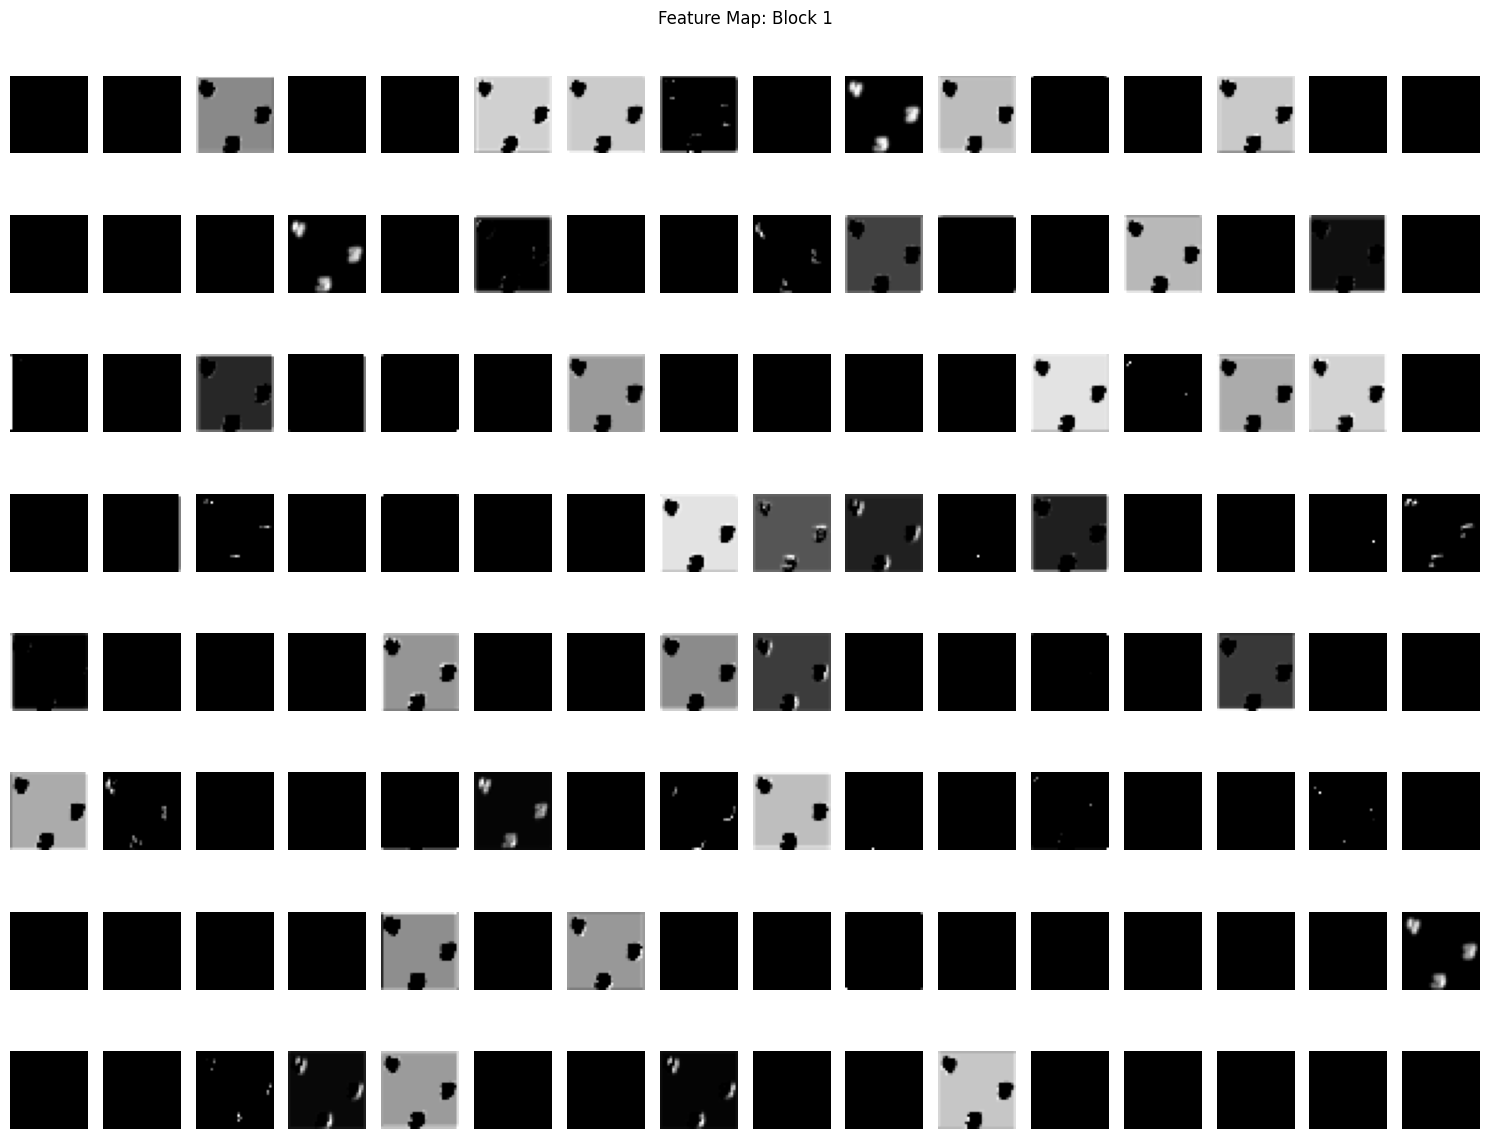

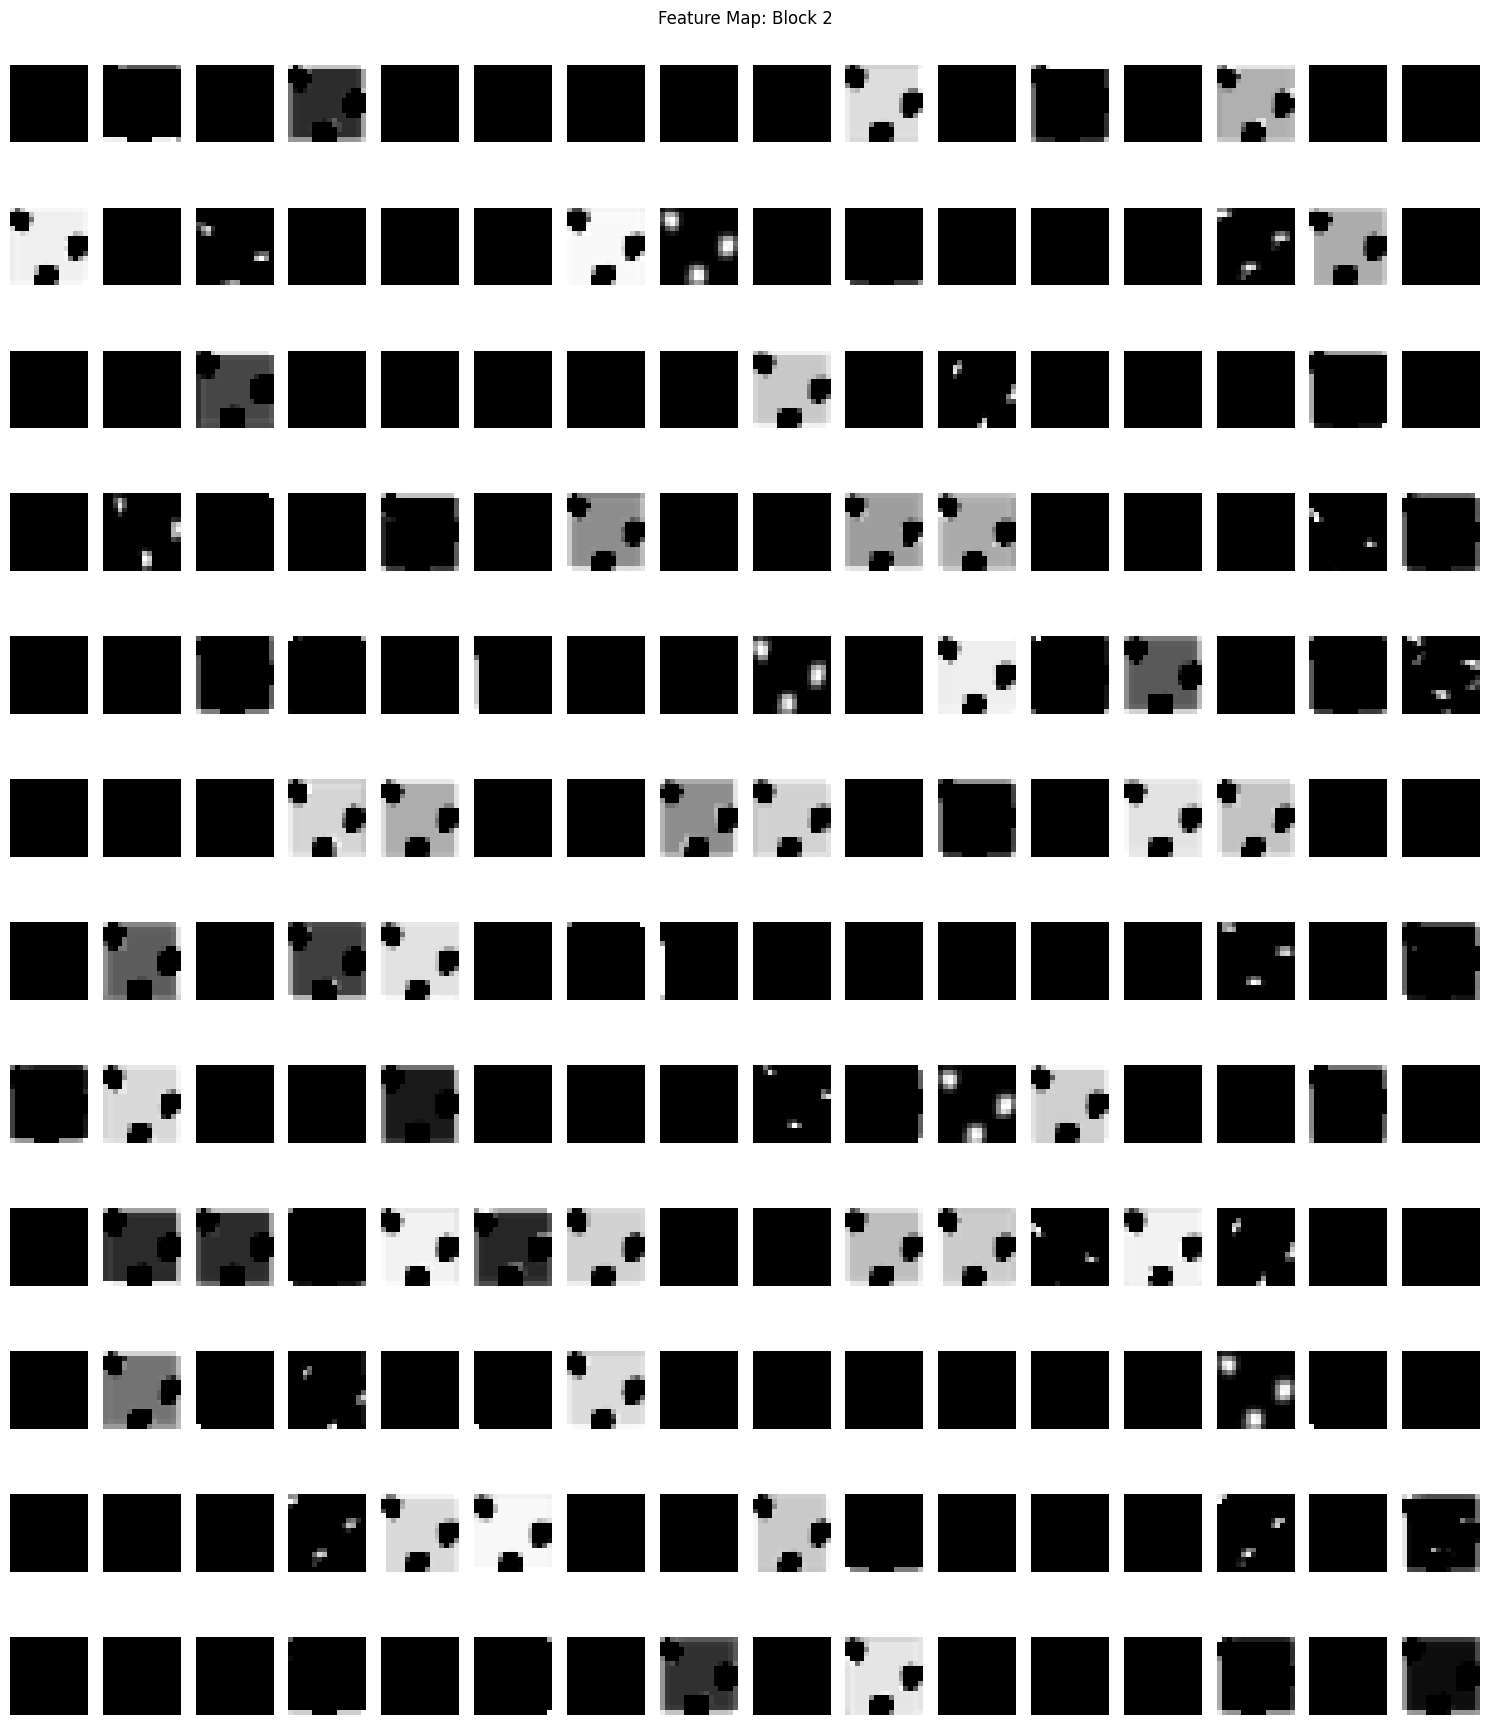

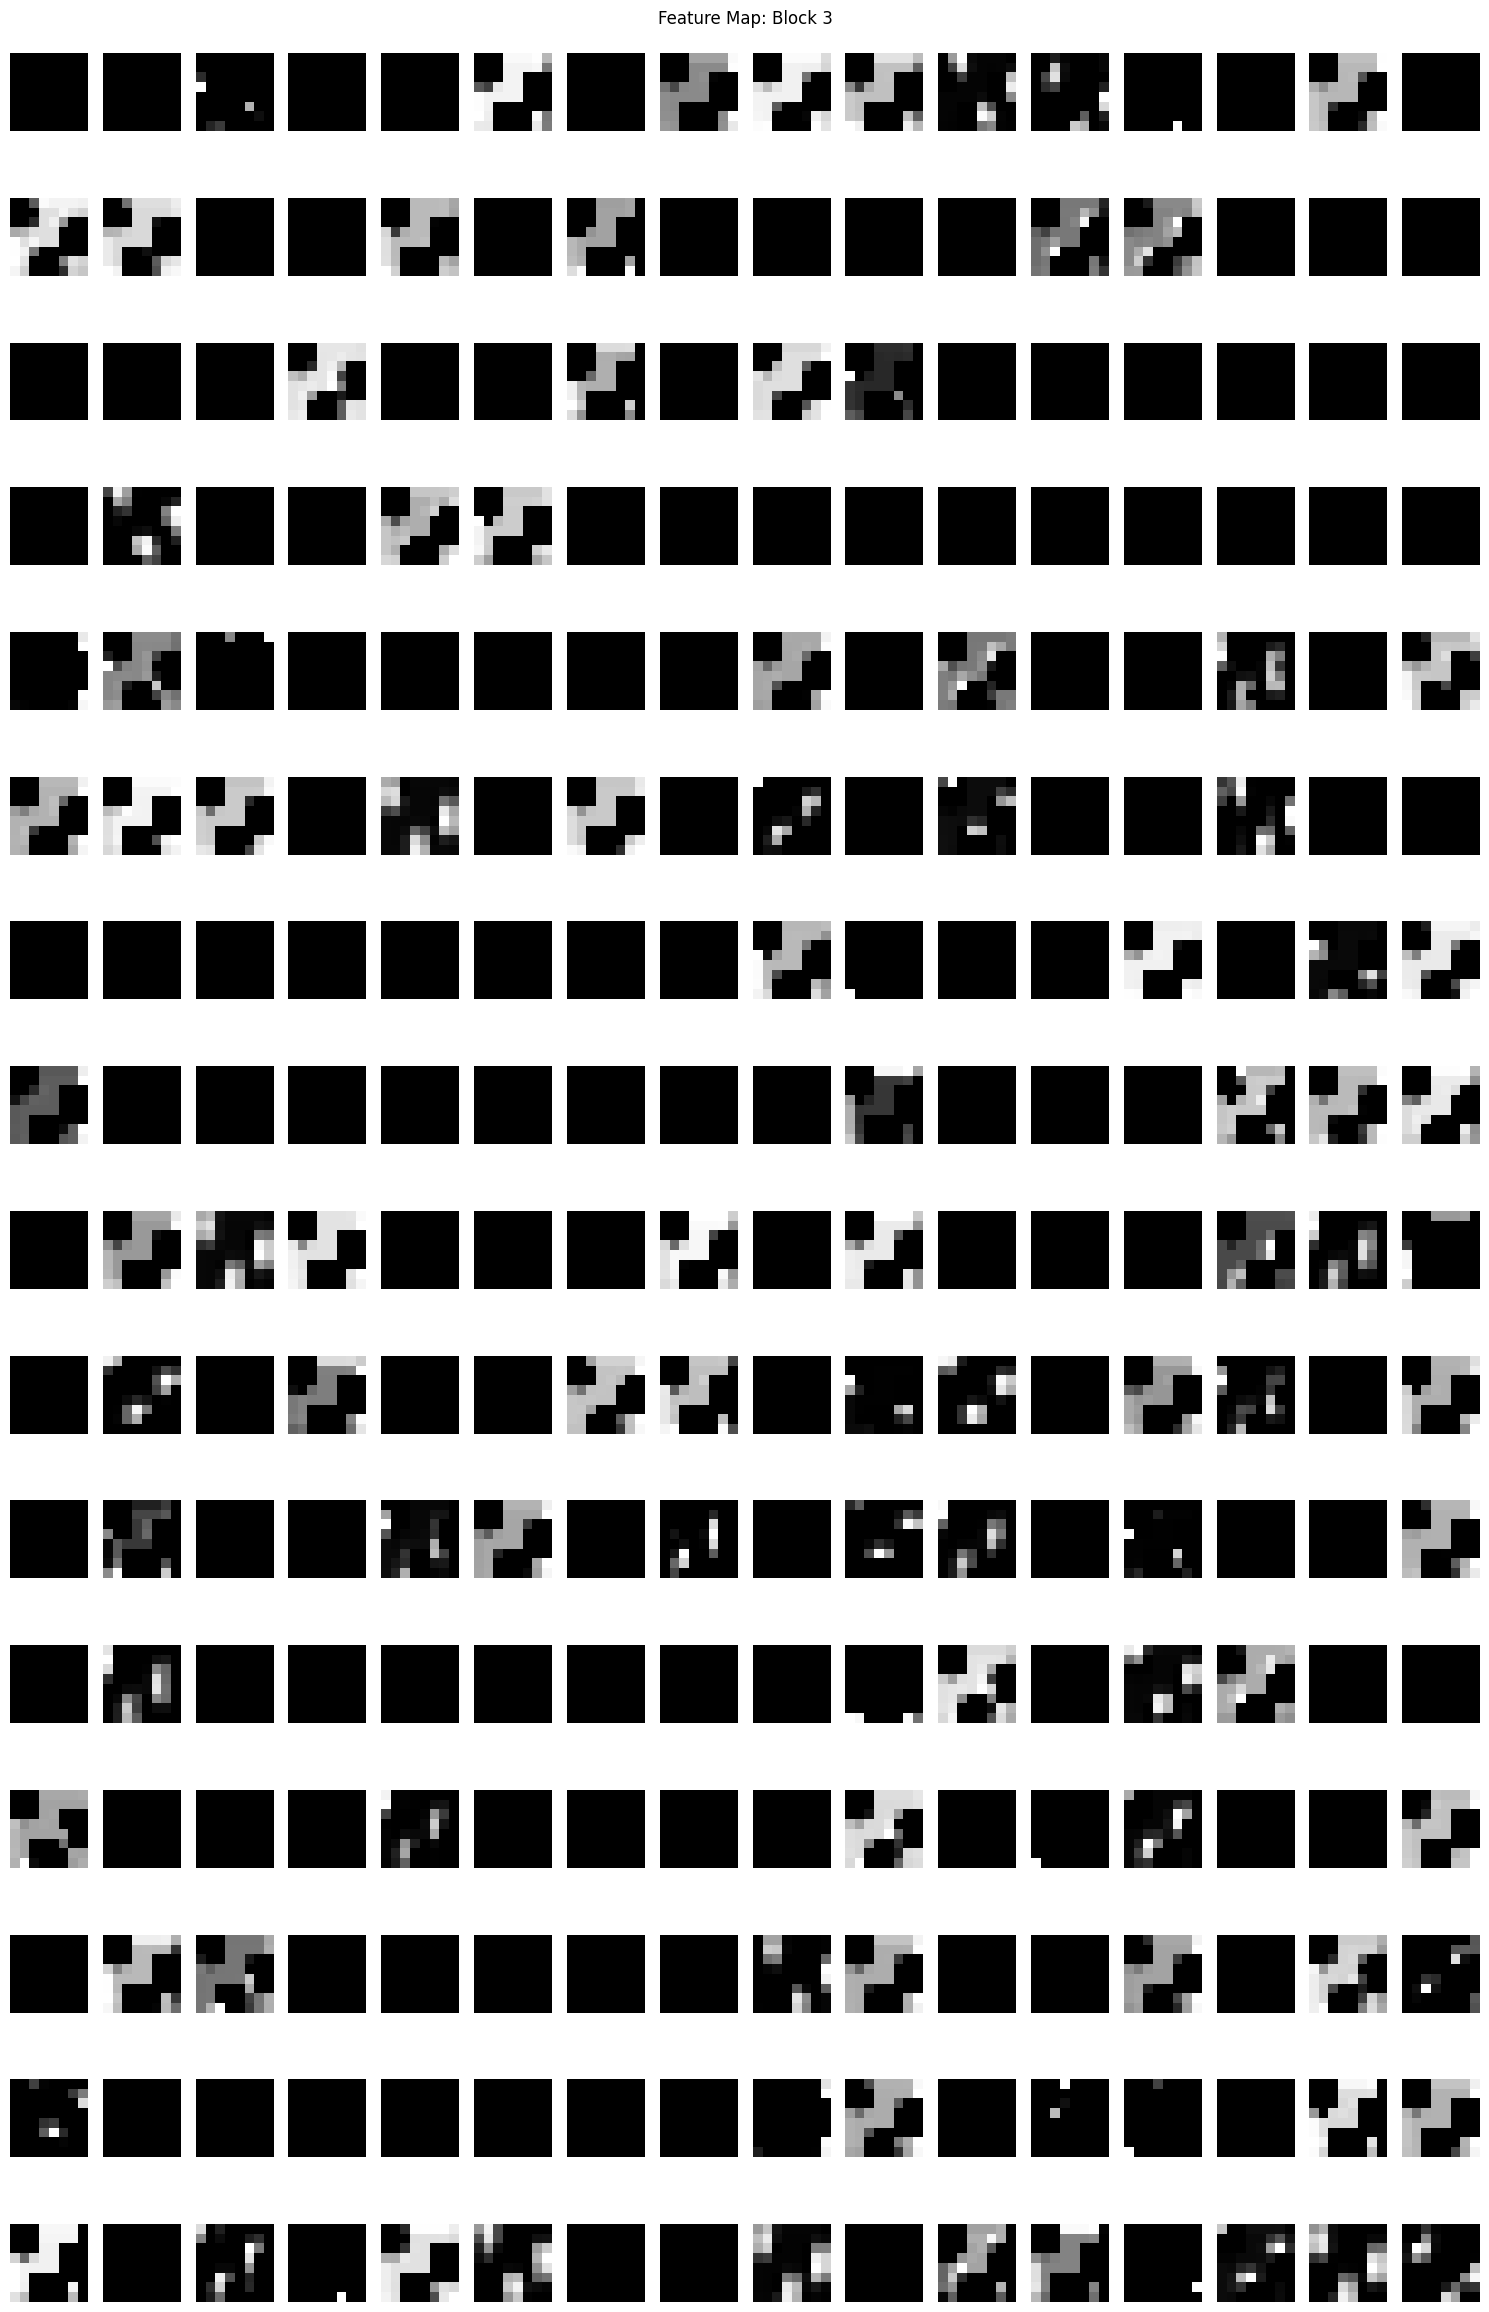

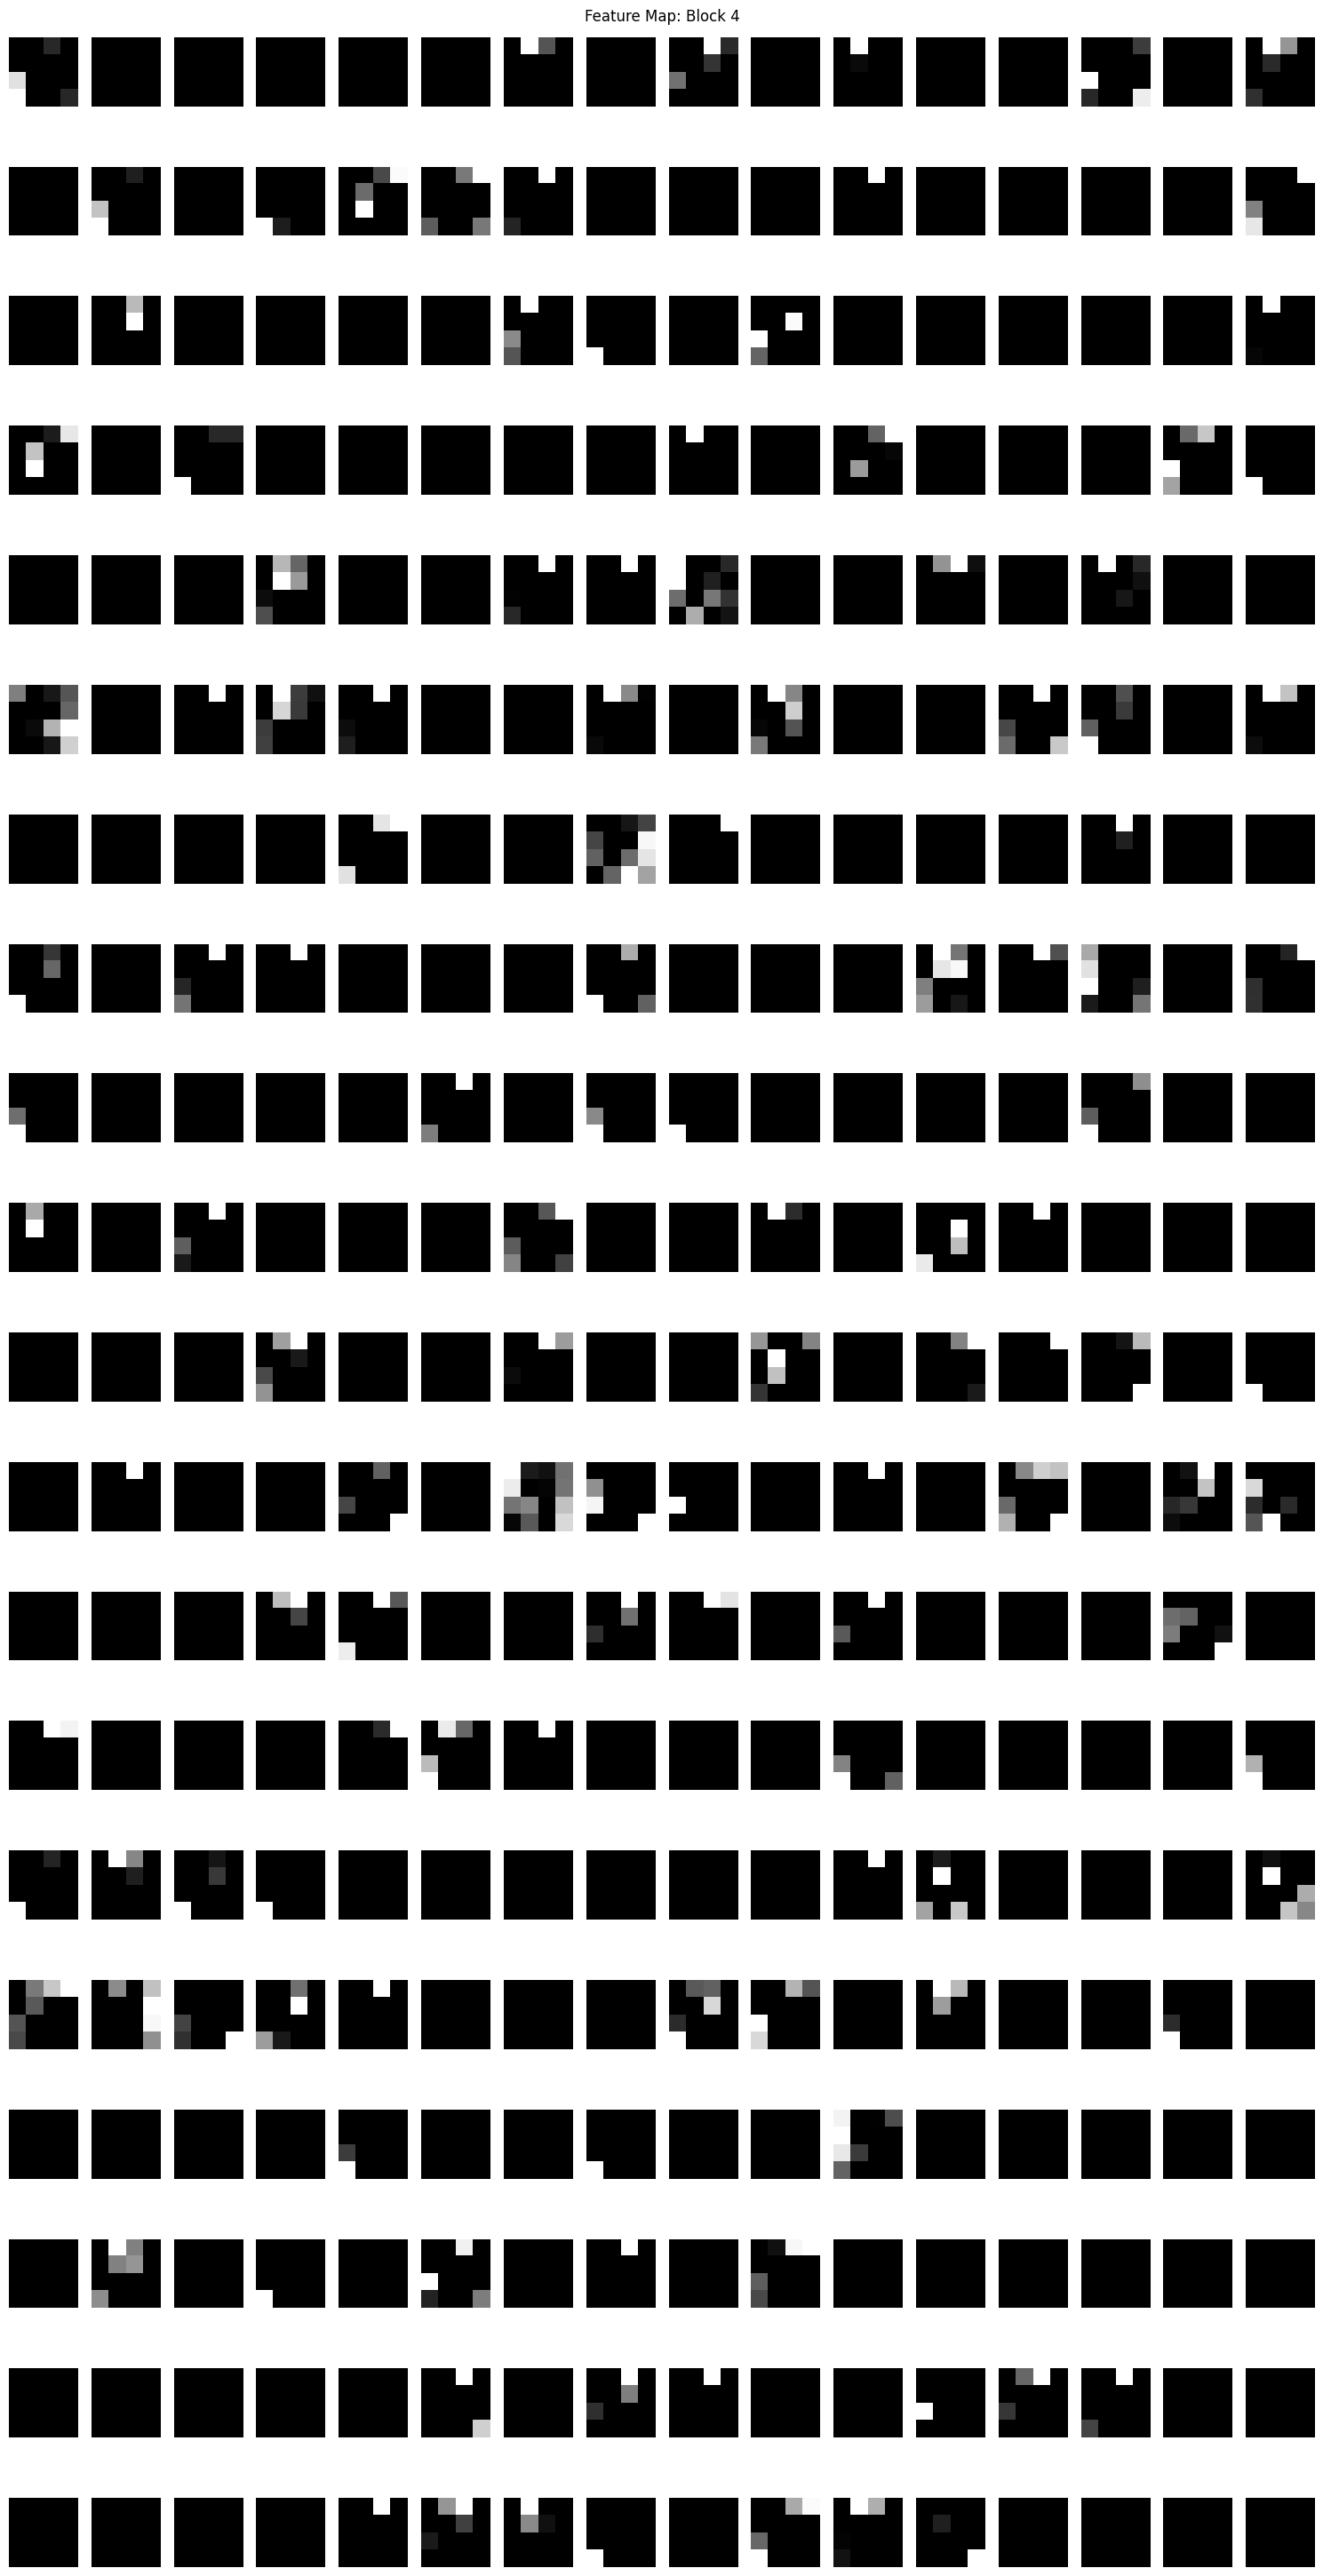

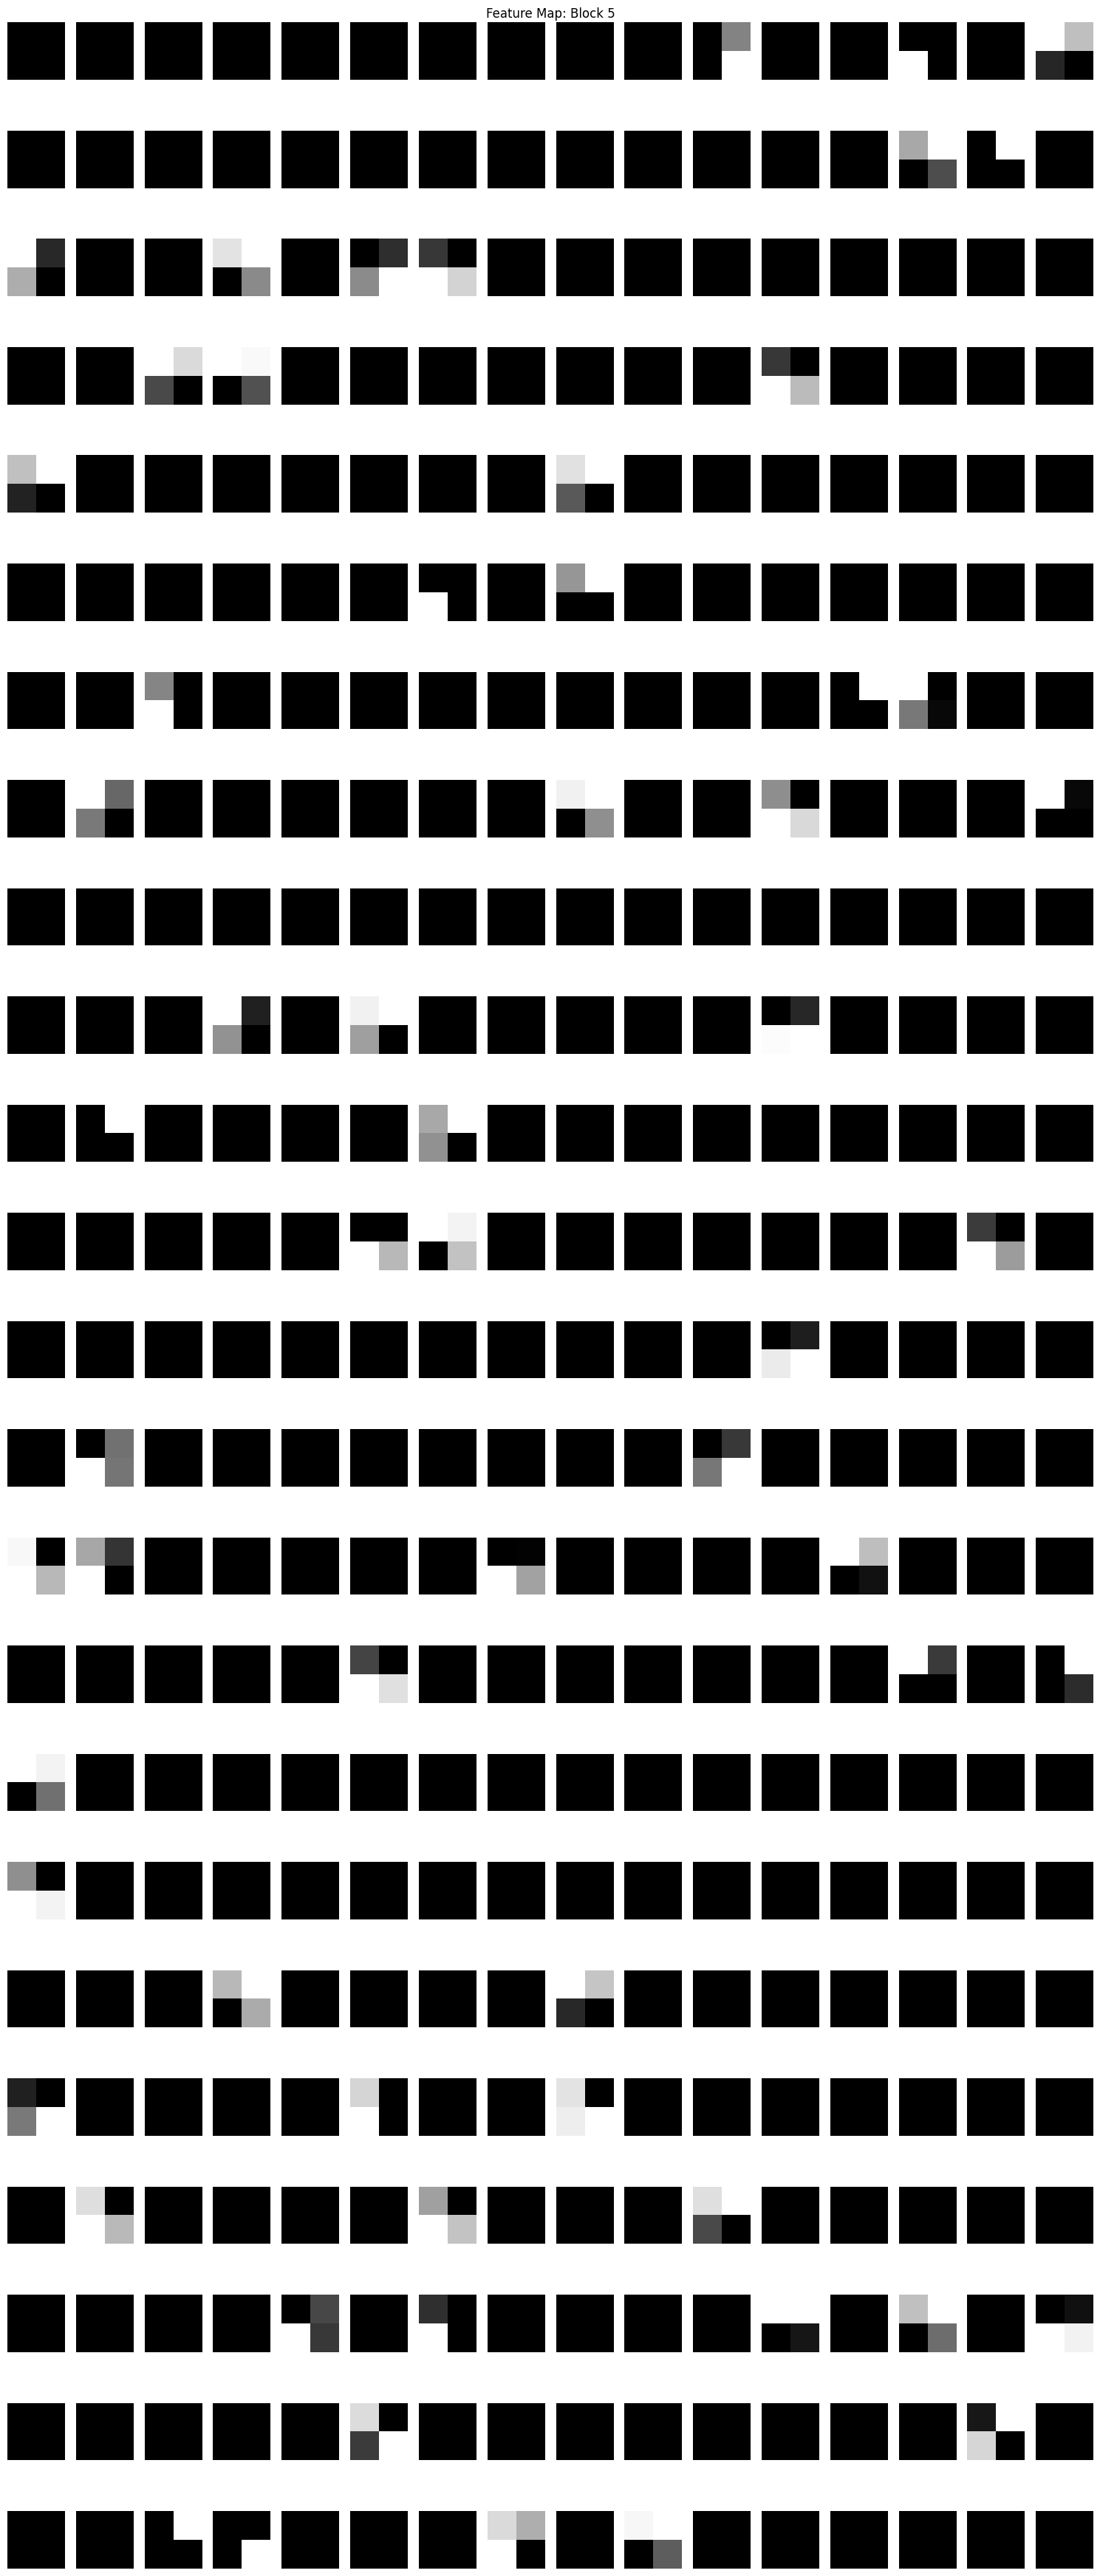

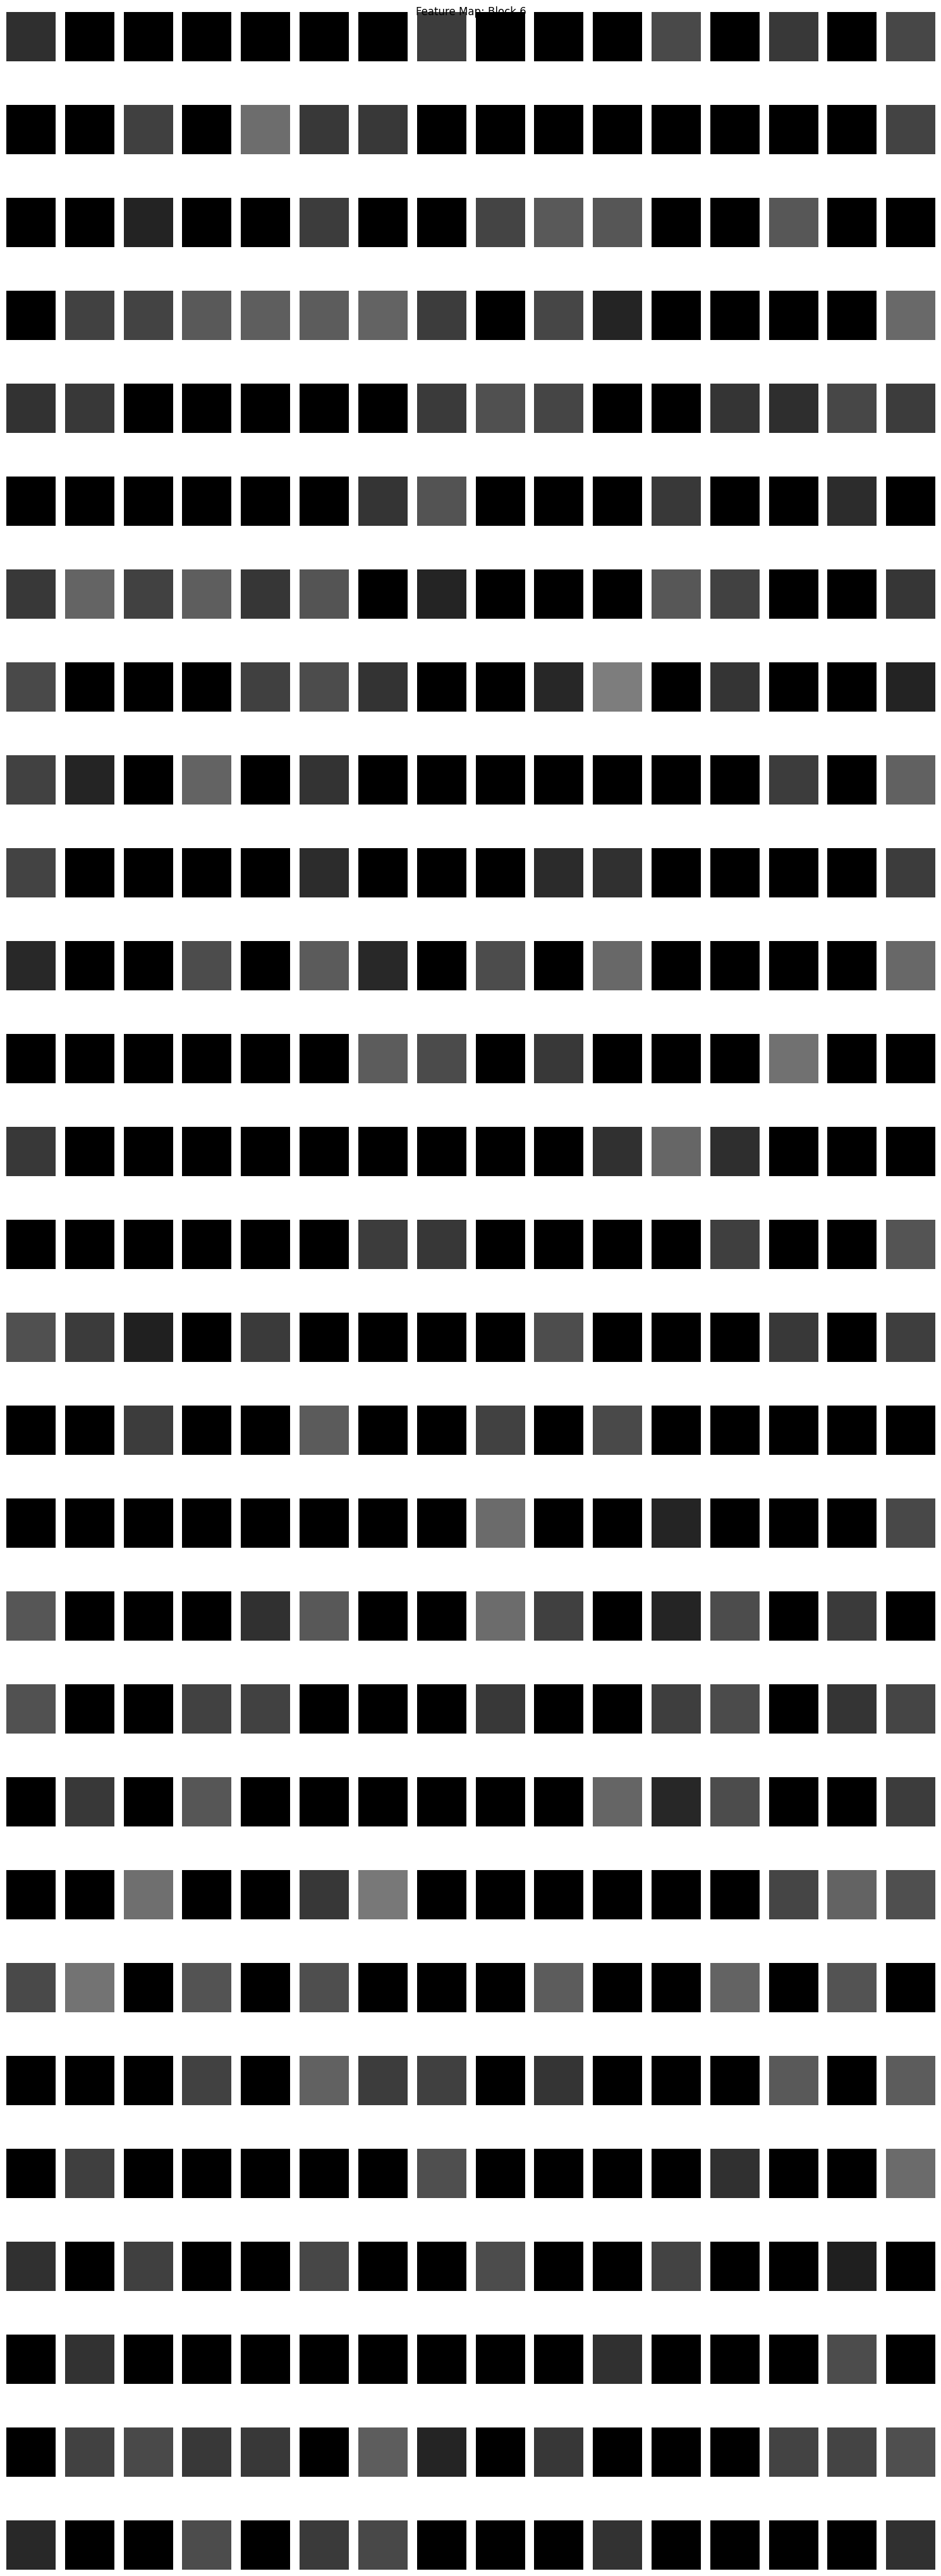

In [67]:
visualize_feature_maps(feature_maps, image_idx=2, num_blocks=regression_cnn.num_blocks)

## Multi Label Classification

### Data Loading and Preprocessing

In [15]:
train_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'train', 'predict')
val_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'val', 'predict')
test_dataset = MultiMNISTDataset(f'{PROJECT_DIR}/data/external/double_mnist', 'test', 'predict')

### Hyperparameter Tuning

In [16]:
# def multi_label_classification_train_worker():
#     train_worker(task='multi-label-classification')

# multi_label_classification_sweep_config = {
#     'name': 'multi-label-classification-hyperparameter-tuning',
#     'method': 'grid',
#     'metric': { 'name': 'val_loss', 'goal': 'minimize' },
#     'parameters': {
#         'dropout': { 'values': [0, 0.2, 0.4] },
#         'lr': { 'values': [1e-5, 1e-4] },
#         'num_blocks': { 'values': [2, 4] },
#         'optimizer': { 'values': ['sgd', 'adam'] },
#     }
# }

# multi_label_classification_sweep_id = wandb.sweep(multi_label_classification_sweep_config, project='smai-m24-cnn')
# wandb.agent(multi_label_classification_sweep_id, multi_label_classification_train_worker)
# wandb.finish()
# shutil.rmtree('wandb')

In [17]:
with open(f'{PROJECT_DIR}/assignments/4/results/cnn_multi_label_classification_hyperparameters.json', \
                                                                'r', encoding='utf-8') as file:
    config = json.load(file)

multi_label_cnn = CNN(
    task='multi-label-classification',
    activation='relu',
    pool='maxpool',
    dropout=config['dropout'],
    lr=config['lr'],
    num_blocks=config['num_blocks'],
    optimizer=config['optimizer']
)
multi_label_cnn.fit(train_dataset, val_dataset, verbose=True)
print()

train_pred = multi_label_cnn.predict(train_dataset)
train_exact_acc = (train_pred == train_dataset[:][1]).all(dim=1).float().mean()
train_hamming_acc = (train_pred == train_dataset[:][1]).float().mean()
print(f'Train exact match accuracy: {train_exact_acc}')
print(f'Train hamming accuracy: {train_hamming_acc}')

val_pred = multi_label_cnn.predict(val_dataset)
val_exact_acc = (val_pred == val_dataset[:][1]).all(dim=1).float().mean()
val_hamming_acc = (val_pred == val_dataset[:][1]).float().mean()
print(f'Validation exact match accuracy: {val_exact_acc}')
print(f'Validation hamming accuracy: {val_hamming_acc}')

test_pred = multi_label_cnn.predict(test_dataset)
test_exact_acc = (test_pred == test_dataset[:][1]).all(dim=1).float().mean()
test_hamming_acc = (test_pred == test_dataset[:][1]).float().mean()
print(f'Test exact match accuracy: {test_exact_acc}')
print(f'Test hamming accuracy: {test_hamming_acc}')

Epoch 0, Train Loss: 0.26781501647482064, Val Loss: 0.23944657743769757
Epoch 1, Train Loss: 0.22511454501430395, Val Loss: 0.22760206781961817
Epoch 2, Train Loss: 0.2106853499252179, Val Loss: 0.2157334713166223
Epoch 3, Train Loss: 0.18959895513838318, Val Loss: 0.19025367749557692
Epoch 4, Train Loss: 0.1538734882880891, Val Loss: 0.16856242654575135
Epoch 5, Train Loss: 0.1218665002793225, Val Loss: 0.14726465555314133
Epoch 6, Train Loss: 0.09891588977410407, Val Loss: 0.13200361007561986
Epoch 7, Train Loss: 0.08150802585792723, Val Loss: 0.12727232795534407
Epoch 8, Train Loss: 0.06359665166246256, Val Loss: 0.11429210106879065
Epoch 9, Train Loss: 0.04741603858428558, Val Loss: 0.11009380174039293

Train exact match accuracy: 0.845634937286377
Train hamming accuracy: 0.9933121800422668
Validation exact match accuracy: 0.429666668176651
Validation hamming accuracy: 0.9737222194671631
Test exact match accuracy: 0.34217390418052673
Test hamming accuracy: 0.9685289859771729
